**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_1_1_)    
      - [Importing Python Libraries](#toc1_1_1_1_)    
      - [Loading Clean Dataset](#toc1_1_1_2_)    
    - [Target column](#toc1_1_2_)    
    - [Dealing with product title, description and feature columns](#toc1_1_3_)    
      - [Tokenizing Product titles and descriptions](#toc1_1_3_1_)    
      - [Product title length](#toc1_1_3_2_)    
    - [Dealing with store column](#toc1_1_4_)    
    - [Product Age](#toc1_1_5_)    
    - [ Sub_categories and Department columns](#toc1_1_6_)    
      - [Aggregating ratings per combined-category](#toc1_1_6_1_)    
      - [Checking Department column](#toc1_1_6_2_)    
    - [Package Dimensions](#toc1_1_7_)    
    - [Pickling final dataframe](#toc1_1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introduction](#toc0_)

In this notebook, we perform pre-processing on different columns in the cleaned meta dataset to prepare the data for modeling. We also explore various opportunities of feature engineering and analyze their trends with respect to the target variable.

#### <a id='toc1_1_1_1_'></a>[Importing Python Libraries](#toc0_)

Importing necessary libraries for data pre-processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS,TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import string
import spacy
import unicodedata

# Ignore all warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Useful settings

plt.rcParams['figure.figsize'] = (8.0, 6.0) # set matplotlib global settings eg. figsize
# plt.rcParams['font.size']=17              # useful when saving figures
sns.set_style("darkgrid")                   #Setting grid style in seaborn

# Uncomment if necessary
#pd.set_option('display.max_columns', None) # show all dataframe columns
#pd.set_option('display.max_colwidth', 1000)  # display long column titles

# from warnings import filterwarnings
# filterwarnings(action='ignore')

#### <a id='toc1_1_1_2_'></a>[Loading Clean Dataset](#toc0_)

In [3]:
# Here we load the pickled combined DataFrame which has undergone basic cleaning 
meta_df = pd.read_pickle('../data/meta_sample_handmade.pkl')
meta_df.head()

,main_category,title,average_rating,rating_number,features,description_product,price,images,videos_product,store,...,sub_category_4,combined_category,Package Dimensions,orig_department,date_first_available,package_weight_ounces,package_length_inches,package_width_inches,package_height_inches,department
0,Handmade,Sterling Silver Hammered Ear Cuff,4.4,243,"[Solid Sterling Silver, Artisan Handcrafted, C...",[This simple ear cuff is made with solid Sterl...,24.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Twisted Designs Jewelry,...,NaN,Jewelry Earrings Ear Cuff,3.62 x 2.05 x 0.83 inches; 0.46 Ounces,unisex-adult,2015-10-27,0.46,3.62,2.05,0.83,unisex
1,Handmade,Witch Cigarette Case Business Card ID Holder W...,5.0,1,[],[This silver-tone metal case can be used as a ...,12.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,...,Cigarette Cases,Clothing Shoes & Accessories Luggage Travel Ge...,NaN,unisex-adult,2018-01-10,NaN,NaN,NaN,NaN,unisex
2,Handmade,"Humorous Cat Wall Art - Decor for Home, Office...",4.5,108,[8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign...,[8x10 UNFRAMED Prints],12.95,[{'thumb': 'https://m.media-amazon.com/images/...,[],YELLOWBIRD ART & DESIGN,...,NaN,Home & Kitchen Artwork Prints,11.2 x 8.8 x 0.2 inches; 3.21 Ounces,NaN,2019-11-05,3.21,11.20,8.80,0.20,NaN
3,Handmade,Whiskey Glasses by Black Lantern – Floral Whis...,4.4,11,[PREMIUM GLASSWARE READY TO GIFT - Our glasses...,[],31.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Black Lantern,...,Glassware,Home & Kitchen Dining Tableware Glassware Tumb...,9 x 7 x 5 inches,NaN,2016-01-26,NaN,9.00,7.00,5.00,NaN
4,Handmade,LOVE Dog Paw Print Heart Sticker Decal Compati...,4.1,3,[],"[Decal Size: 1"" Tall X 3.2"" Wide Die cut out o...",3.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,...,NaN,Electronics Accessories Laptop Skins & Decals,NaN,Womens,2016-11-14,NaN,NaN,NaN,NaN,women


In [4]:
#While these columns have only been retained for reference, they are redundant and will be dropped from further analysis 
meta_df.drop(columns=['categories','details','orig_department','Package Dimensions','main_category' ],inplace=True)


In [5]:
#Checking the columns with data type as object

meta_df_cat = meta_df.select_dtypes(include="O")

print(f'The categorical columns in the combined dataset are {meta_df_cat.columns.tolist()}.')


The categorical columns in the combined dataset are ['title', 'features', 'description_product', 'images', 'videos_product', 'store', 'parent_asin', 'sub_category_1', 'sub_category_2', 'sub_category_3', 'sub_category_4', 'combined_category', 'department'].


### Number of Ratings

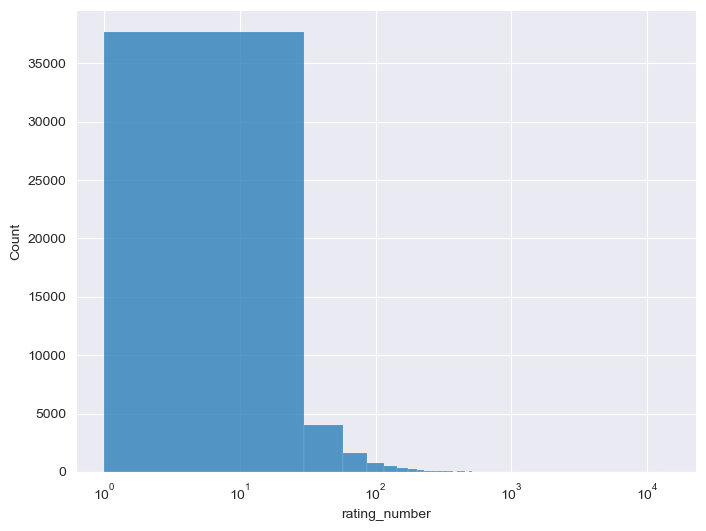

In [6]:
sns.histplot(x='rating_number', data=meta_df,bins=500)
plt.xscale('log')
plt.show()

In [7]:
meta_df['rating_number'].describe()

count    46165.000000
mean        29.381783
std        137.742687
min          1.000000
25%          2.000000
50%          6.000000
75%         20.000000
max      14235.000000
Name: rating_number, dtype: float64

Most of the products have only 1 rating indicating that their average rating is not a reliable indicator of customer satisfaction. We will only choose products with atleast 2 ratings as that allows us to use atleast 75 percent of the data.

In [8]:
meta_df = meta_df[meta_df['rating_number'] >1]
meta_df = meta_df.reset_index(drop=True)
meta_df.shape

(38154, 21)

### <a id='toc1_1_2_'></a>[Target column](#toc0_)

In [9]:
#create a new column that could be used as a more balanced target variable

meta_df['highly_rated_product'] = np.where(meta_df['average_rating'] > 4.5,1,0) 

meta_df['highly_rated_product'].value_counts(normalize=True)



highly_rated_product
1    0.544268
0    0.455732
Name: proportion, dtype: float64

`highly_rated_item` column  classifies whether a product will get an average rating > 4.5 as well average user rating > 4.5. As we can see that our dataset is roughly balanced for this target freature.

### Product Videos and Images

While I will not be using the images directly in my analysis, it would be interesting to see if products that are usually accompanied by more images and videos from the seller tend to get higher scores. Similarly, it would be interesting to see if users that post an image in their review tend to give higher ratings.

In [10]:
meta_df[['images','videos_product']].head()

,images,videos_product
0,[{'thumb': 'https://m.media-amazon.com/images/...,[]
1,[{'thumb': 'https://m.media-amazon.com/images/...,[]
2,[{'thumb': 'https://m.media-amazon.com/images/...,[]
3,[{'thumb': 'https://m.media-amazon.com/images/...,[]
4,[{'thumb': 'https://m.media-amazon.com/images/...,[]


In [11]:
#checking products with missing videos
meta_df['videos_product'].apply(len).value_counts(normalize=True)

videos_product
0    0.999921
1    0.000026
7    0.000026
2    0.000026
Name: proportion, dtype: float64

In [12]:
#checking products with missing images
meta_df['images'].apply(len).describe()

count    38154.000000
mean         5.427268
std          2.582503
min          1.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         15.000000
Name: images, dtype: float64

More than 99% of products have missing videos therefore we will be dropping this column.

All products have atleast one image with some of them having upto 15 images.

Lets investigate the images further.

In [13]:
#code to separate  different components of dictionary stored in images_product column into a dataframe

# Explode the `images_product` column into separate rows
exploded_df = meta_df[['images','parent_asin']].explode('images').reset_index(drop=True)
exploded_df.head(10)
# Expand the dictionaries into separate columns
expanded_df = pd.json_normalize(exploded_df['images'])

#Merge the two dataframes
product_images_df = pd.concat([exploded_df.drop(columns=['images']), expanded_df], axis=1)
product_images_df.head(10)

,parent_asin,thumb,large,variant,hi_res
0,B0178HXZUY,https://m.media-amazon.com/images/I/21Of6GkbHa...,https://m.media-amazon.com/images/I/21Of6GkbHa...,MAIN,https://m.media-amazon.com/images/I/61W5hP4O9v...
1,B0178HXZUY,https://m.media-amazon.com/images/I/310AIVj1O7...,https://m.media-amazon.com/images/I/310AIVj1O7...,PT01,https://m.media-amazon.com/images/I/519RsTsDb6...
2,B0178HXZUY,https://m.media-amazon.com/images/I/31mtka0nwn...,https://m.media-amazon.com/images/I/31mtka0nwn...,PT02,https://m.media-amazon.com/images/I/71PcZ7Nu5r...
3,B07ZFJXDH8,https://m.media-amazon.com/images/I/41FFscHki0...,https://m.media-amazon.com/images/I/41FFscHki0...,MAIN,https://m.media-amazon.com/images/I/51F87SY4Et...
4,B07ZFJXDH8,https://m.media-amazon.com/images/I/51y28ic7qY...,https://m.media-amazon.com/images/I/51y28ic7qY...,PT01,https://m.media-amazon.com/images/I/61v15YpzSK...
5,B07ZFJXDH8,https://m.media-amazon.com/images/I/410tvo8dBh...,https://m.media-amazon.com/images/I/410tvo8dBh...,PT02,https://m.media-amazon.com/images/I/61robXhMYk...
6,B07ZFJXDH8,https://m.media-amazon.com/images/I/51ZJo1mHXq...,https://m.media-amazon.com/images/I/51ZJo1mHXq...,PT03,https://m.media-amazon.com/images/I/61wzJGHbgd...
7,B07ZFJXDH8,https://m.media-amazon.com/images/I/51I9fVLUlX...,https://m.media-amazon.com/images/I/51I9fVLUlX...,PT04,https://m.media-amazon.com/images/I/613peNncX7...
8,B07ZFJXDH8,https://m.media-amazon.com/images/I/41kTRK2ZD+...,https://m.media-amazon.com/images/I/41kTRK2ZD+...,PT06,https://m.media-amazon.com/images/I/61JbWivq+I...
9,B07ZFJXDH8,https://m.media-amazon.com/images/I/51EdES61mS...,https://m.media-amazon.com/images/I/51EdES61mS...,PT07,https://m.media-amazon.com/images/I/619owIJerh...


In [14]:
agg_df = product_images_df.groupby('parent_asin',as_index=False)[['thumb', 'large', 'variant', 'hi_res']].nunique()
agg_df.sort_values(by='variant',ascending=False).head()

agg_df.head()

,parent_asin,thumb,large,variant,hi_res
0,B0003TOQIK,3,3,3,3
1,B000406CNA,3,3,3,3
2,B0004K4BO2,2,2,2,1
3,B0004K4D40,2,2,2,1
4,B0004K4TCQ,3,3,3,3


In [15]:
agg_df.describe()

,thumb,large,variant,hi_res
count,38154.000000,38154.000000,38154.000000,38154.000000
mean,5.396918,5.396918,5.427268,4.725979
std,2.577273,2.577273,2.582503,2.793518
min,1.000000,1.000000,1.000000,0.000000
25%,3.000000,3.000000,3.000000,2.000000
50%,5.000000,5.000000,6.000000,5.000000
75%,8.000000,8.000000,8.000000,7.000000
max,15.000000,15.000000,15.000000,13.000000


In [16]:
meta_df = meta_df.merge(agg_df, on='parent_asin')
meta_df.head()

,title,average_rating,rating_number,features,description_product,price,images,videos_product,store,parent_asin,...,package_weight_ounces,package_length_inches,package_width_inches,package_height_inches,department,highly_rated_product,thumb,large,variant,hi_res
0,Sterling Silver Hammered Ear Cuff,4.4,243,"[Solid Sterling Silver, Artisan Handcrafted, C...",[This simple ear cuff is made with solid Sterl...,24.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Twisted Designs Jewelry,B0178HXZUY,...,0.46,3.62,2.05,0.83,unisex,0,3,3,3,3
1,"Humorous Cat Wall Art - Decor for Home, Office...",4.5,108,[8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign...,[8x10 UNFRAMED Prints],12.95,[{'thumb': 'https://m.media-amazon.com/images/...,[],YELLOWBIRD ART & DESIGN,B07ZFJXDH8,...,3.21,11.20,8.80,0.20,NaN,0,8,8,8,8
2,Whiskey Glasses by Black Lantern – Floral Whis...,4.4,11,[PREMIUM GLASSWARE READY TO GIFT - Our glasses...,[],31.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Black Lantern,B089LRPX7X,...,NaN,9.00,7.00,5.00,NaN,0,8,8,8,8
3,LOVE Dog Paw Print Heart Sticker Decal Compati...,4.1,3,[],"[Decal Size: 1"" Tall X 3.2"" Wide Die cut out o...",3.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,B01MXKS1L5,...,NaN,NaN,NaN,NaN,women,0,2,2,2,1
4,"Bachelorette Party Shirts, Soft Crew Neck and ...",4.6,64,"[Tear Away Label, Machine Wash, Made in the US...",[Shop now our unique set of bachelorette shirt...,15.59,[{'thumb': 'https://m.media-amazon.com/images/...,[],PATYZ,B07Q5VXBCC,...,NaN,10.00,8.00,1.00,unisex,1,8,8,8,8


In [17]:
#storing number of images per product
meta_df['num_product_images'] = meta_df[['thumb','large','variant','hi_res']].fillna(0).max(axis=1)

#drop original columns
meta_df.drop(columns=['videos_product','images','thumb','large','variant','hi_res'],inplace=True)

meta_df['num_product_images'].describe()

count    38154.000000
mean         5.427268
std          2.582503
min          1.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         15.000000
Name: num_product_images, dtype: float64

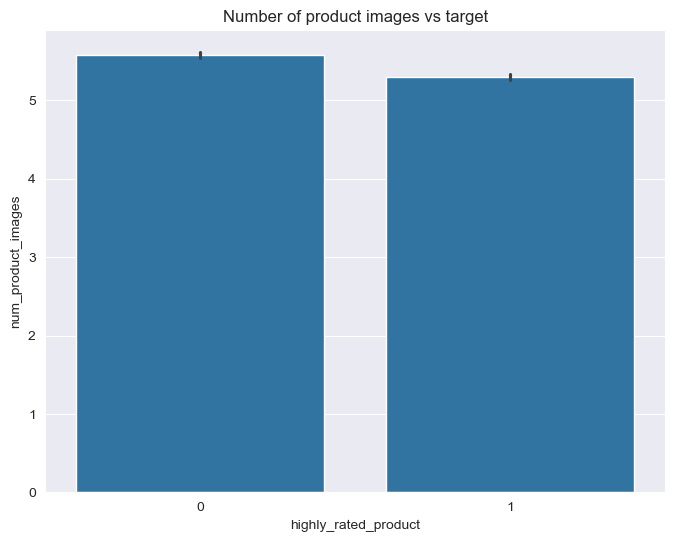

In [18]:
#checking the distribution of number of product images across the target variable
sns.barplot(data=meta_df,x='highly_rated_product',y='num_product_images')
plt.title('Number of product images vs target')
plt.show()

We don't see a strong correlation between the number of product images and average rating of the product, likely due to the imbalance in our data towards higher ratings.

### <a id='toc1_1_3_'></a>[Dealing with product title, description and feature columns](#toc0_)

All the three columns contain important textual details about the product and could act as an important differentiator about the product's quality and thus their rating. In this section, we will clean these columns and combine the meaningful tokens from each of them to prepare them for vectorization.

In [19]:
#checking first few rows of product title
meta_df['title'].head()

0                    Sterling Silver Hammered Ear Cuff
1    Humorous Cat Wall Art - Decor for Home, Office...
2    Whiskey Glasses by Black Lantern – Floral Whis...
3    LOVE Dog Paw Print Heart Sticker Decal Compati...
4    Bachelorette Party Shirts, Soft Crew Neck and ...
Name: title, dtype: object

In [20]:
#checking first few rows of product description
meta_df['description_product'].head()

0    [This simple ear cuff is made with solid Sterl...
1                               [8x10 UNFRAMED Prints]
2                                                   []
3    [Decal Size: 1" Tall X 3.2" Wide Die cut out o...
4    [Shop now our unique set of bachelorette shirt...
Name: description_product, dtype: object

In [21]:
#checking first few rows of product features
meta_df['features'].head()

0    [Solid Sterling Silver, Artisan Handcrafted, C...
1    [8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign...
2    [PREMIUM GLASSWARE READY TO GIFT - Our glasses...
3                                                   []
4    [Tear Away Label, Machine Wash, Made in the US...
Name: features, dtype: object

Since Description and Features columns contains lists, we will first need to split all the elements of the list and combine them into a single string to prepare each row for tokenization.

In [22]:
meta_df['description_product'] = meta_df['description_product'].apply(lambda x: ' '.join(x))
meta_df['features'] = meta_df['features'].apply(lambda x: ' '.join(x))

In [23]:
meta_df["product_features"] = meta_df["title"] + " " + meta_df["description_product"] + meta_df["features"]
meta_df['product_features'].head().values.tolist()

['Sterling Silver Hammered Ear Cuff This simple ear cuff is made with solid Sterling Silver. I have shaped, hammered and polished it carefully by hand. The beautiful hammer marks catch the light beautifully. It fits on the upper ear or the mid ear. It will arrive in nice little jewelry box. Enjoy! These are in stock and ready to ship right away!Solid Sterling Silver Artisan Handcrafted Comes in Gift Box',
 'Humorous Cat Wall Art - Decor for Home, Office or Apartment Decoration - 8x10 Picture Poster Makes Great Gift - Unframed Typography Photo Print 8x10 UNFRAMED Prints8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign UNIQUE WALL ART DECOR - Cool original home decorations for office, living room, bedroom, bathroom, family room, man cave, dorm, dining room, kitchen, classroom, apartment, bar, baby nursery PERFECT PRESENT FOR EVERY OCCASION - Cute gift ideas for women, wife, girlfriend, her, girls, daughter, men, guys, boys, son, husband, boyfriend, him, kids, teens, best friend, cat lover, C

#### <a id='toc1_1_3_1_'></a>[Tokenizing Product titles and descriptions](#toc0_)

In this section, we implement a WordNet and Spacy tokenizer to process the `product_features` column. We then apply a TF-IDF vectorizer to identify important tokens for a few stores. During modeling, we will implement proper vectorization within a pipeline to prevent data leakage.  

In [24]:
# Load the large English pipeline
nlp = spacy.load('en_core_web_lg', disable=["parser", "ner"])  # Disabling parser & NER for efficiency

def normalize_text(text):
    """
    Normalizes text by converting special Unicode characters into standard ASCII.
    """
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return normalized_text

def spacy_tokenizer(row):
    """
    Tokenizes and lemmatizes a product title, normalizing Unicode characters
    and removing stopwords.

    Args:
        row (str): A product title or description.

    Returns:
        str: Processed text with lemmatized words.
    """
    # Normalize Unicode styles
    normalized_text = normalize_text(row)

    # Process text with SpaCy
    parsed_title = nlp(normalized_text)

    # Extract only relevant tokens
    tok_lemmas = [
        token.lemma_.lower()    # Convert lemma to lowercase
        for token in parsed_title 
        if token.is_alpha       # Ensure token is alphabetic
        and not token.is_stop   # Remove stopwords
        and len(token) > 3      # Ignore very short words
        and token.pos_ in ("ADJ", "NOUN", "PROPN")  # Extract nouns and adjectives
    ]

    # Remove duplicates while preserving order
    unique_tokens = list(dict.fromkeys(tok_lemmas))

    return ' '.join(unique_tokens)  # Convert list to a single string

# Apply tokenizer to product features
meta_df['spacy_tokenized_features'] = meta_df['product_features'].astype(str).apply(spacy_tokenizer)

# Display sample output
meta_df[['product_features', 'spacy_tokenized_features']].head()

,product_features,spacy_tokenized_features
0,Sterling Silver Hammered Ear Cuff This simple ...,sterling silver hammered cuff simple solid han...
1,"Humorous Cat Wall Art - Decor for Home, Office...",humorous wall decor home office apartment deco...
2,Whiskey Glasses by Black Lantern – Floral Whis...,whiskey glass black lantern floral glasses flo...
3,LOVE Dog Paw Print Heart Sticker Decal Compati...,love print heart sticker decal compatible ipad...
4,"Bachelorette Party Shirts, Soft Crew Neck and ...",bachelorette party shirts soft crew neck custo...


In [25]:
#Word Net Lemmatizer 

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

# NLTK stopwords
stop_words = set(stopwords.words("english")) 

def wordnet_tokenizer(row):
    """Custom tokenizer function built using WordNet

    Args:
        text (str): Provided text data

    Returns:
        list: List of tokens
    """
    #Tokenize using NLTK
    tokens = word_tokenize(row)

    #Convert the tokens into lowercase: lower_tokens
    lower_tokens = [t.lower() for t in tokens]

    #Retain alphabetic words only
    alpha_only = [tok for tok in lower_tokens if tok.isalpha()]
    
    #Remove stop words
    no_stops = [tok for tok in alpha_only if tok not in stop_words]

    # Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer() 

    #Apply Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in no_stops if len(token)> 2]

    #Instantiate Stemmer
    #stemmer = PorterStemmer() 

    #Remove single letter tokens after stemming
    final_tokens = [tok for tok in lemmatized_tokens if len(tok) > 2]


    # Remove duplicate tokens while maintaining order
    unique_tokens = list(dict.fromkeys(lemmatized_tokens))

    return unique_tokens

#apply custom tokenizer on product features
meta_df['wordnet_tokenized_features'] = meta_df['product_features'].apply(wordnet_tokenizer) 

#Split words in the list to form a string
meta_df["wordnet_tokenized_features"] = meta_df["wordnet_tokenized_features"].apply(lambda x: ' '.join(x))


In [26]:
#inspect the input
meta_df['product_features'].head().tolist()

['Sterling Silver Hammered Ear Cuff This simple ear cuff is made with solid Sterling Silver. I have shaped, hammered and polished it carefully by hand. The beautiful hammer marks catch the light beautifully. It fits on the upper ear or the mid ear. It will arrive in nice little jewelry box. Enjoy! These are in stock and ready to ship right away!Solid Sterling Silver Artisan Handcrafted Comes in Gift Box',
 'Humorous Cat Wall Art - Decor for Home, Office or Apartment Decoration - 8x10 Picture Poster Makes Great Gift - Unframed Typography Photo Print 8x10 UNFRAMED Prints8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign UNIQUE WALL ART DECOR - Cool original home decorations for office, living room, bedroom, bathroom, family room, man cave, dorm, dining room, kitchen, classroom, apartment, bar, baby nursery PERFECT PRESENT FOR EVERY OCCASION - Cute gift ideas for women, wife, girlfriend, her, girls, daughter, men, guys, boys, son, husband, boyfriend, him, kids, teens, best friend, cat lover, C

In [27]:
#inspect the output from wordnet
meta_df['wordnet_tokenized_features'].head().tolist()

['sterling silver hammered ear cuff simple made solid shaped polished carefully hand beautiful hammer mark catch light beautifully fit upper mid arrive nice little jewelry box enjoy stock ready ship right away artisan handcrafted come gift',
 'humorous cat wall art decor home office apartment decoration picture poster make great gift unframed typography photo print canvas tin sign unique cool original living room bedroom bathroom family man cave dorm dining kitchen classroom bar baby nursery perfect present every occasion cute idea woman wife girlfriend girl daughter men guy boy son husband boyfriend kid teen best friend lover christmas xmas holiday halloween housewarming cheap inexpensive gag bridal shower wedding birthday anniversary many style boho bohemian abstract aesthetic mid century modern minimalist contemporary black african american goth gothic pagan country rustic vintage shabby chic farmhouse positive quote inspirational motivational zen religious christian funny saying na

In [28]:
#inspect the output from spacy
meta_df['spacy_tokenized_features'].head().tolist()

['sterling silver hammered cuff simple solid hand beautiful hammer mark light upper nice little jewelry stock ready artisan handcrafted gift',
 'humorous wall decor home office apartment decoration picture poster great gift unframed typography photo print canvas sign cool original living room bedroom bathroom family cave dorm dining kitchen classroom baby nursery perfect present occasion cute idea woman wife girlfriend girl daughter guy boy husband boyfriend kid teen good friend lover christmas xmas holiday halloween housewarming cheap inexpensive bridal shower wedding birthday anniversary style boho bohemian abstract aesthetic century modern minimalist contemporary black african american goth gothic pagan country rustic vintage shabby chic farmhouse positive quote inspirational motivational religious christian funny saying nautical tropical artwork beach arte decoracion retro encouragement glam multiple pictures detail',
 'whiskey glass black lantern floral glasses flower rock kitchen

In [29]:
#Check for any rows with missing tokens
print(f'There are {len(meta_df["spacy_tokenized_features"].apply(len).loc[lambda x: x ==0])} products with missing features.')
print(f'There are {len(meta_df["wordnet_tokenized_features"].apply(len).loc[lambda x: x ==0])} products with missing features.')

There are 0 products with missing features.
There are 1 products with missing features.


In [30]:
#check rows with missing features
meta_df[meta_df["wordnet_tokenized_features"]== ""].head()

,title,average_rating,rating_number,features,description_product,price,store,parent_asin,sub_category_1,sub_category_2,...,package_weight_ounces,package_length_inches,package_width_inches,package_height_inches,department,highly_rated_product,num_product_images,product_features,spacy_tokenized_features,wordnet_tokenized_features
34912,3 oz / 90 ml/Jicara tradicional/Mexican Jicara...,4.0,7,,,7.4,Generic,B07MX7C1TB,Home & Kitchen,Home Décor,...,NaN,NaN,NaN,NaN,NaN,0,9,3 oz / 90 ml/Jicara tradicional/Mexican Jicara...,jicara tradicional mexican unit,


In [31]:
#meta_df['spacy_tokenized_features'].apply(len).median()
#meta_df['wordnet_tokenized_features'].apply(len).median()

 Since there is only one product with missing title, we could leave it as it is in the dataset.

We will now vectorize the generated tokens for a quick look.

In [32]:
#tfidf using custom tokenizer built using spacy
tfidf_vect_spacy = TfidfVectorizer(
                                   lowercase=True,
                                   min_df=20,
                                   #max_df=0.10,                  
                                   stop_words='english',   
                                   )         #

# Fit 
tfidf_vect_spacy.fit(meta_df['spacy_tokenized_features'])

#Transform - output is a sparse matrix
transformed_spacy_features = tfidf_vect_spacy.transform(meta_df['spacy_tokenized_features'])

#convert to dataframe
spacy_tokens_df  = pd.DataFrame(transformed_spacy_features.toarray(), columns= tfidf_vect_spacy.get_feature_names_out())

print(f'Shape of transformed array of spacy_tokenized features: {spacy_tokens_df.shape}')


Shape of transformed array of spacy_tokenized features: (38154, 5564)


While the tokens from spaCy and WordNet tokenizers appear similar, we could prioritize using spaCy first. The lower word count in spaCy’s output suggests that it might clean the text more effectively.

In [33]:
#checking a few most common tokens in the dataset
spacy_tokens_df.sum(axis=0).sort_values().head(20)

wholesaler         3.387110
infinitygemsart    3.472287
basin              3.494290
rated              3.556698
output             3.572971
exclusivity        3.663769
figurative         3.739500
odrilliongems      3.806688
geography          3.828580
exploration        3.839209
cafeteria          3.874758
silvermetal        3.897426
premise            3.900879
sneakers           3.907172
handicraft         3.939017
unparalleled       3.947595
heated             3.994693
disorder           3.998021
kinetic            4.000564
harmonious         4.010038
dtype: float64

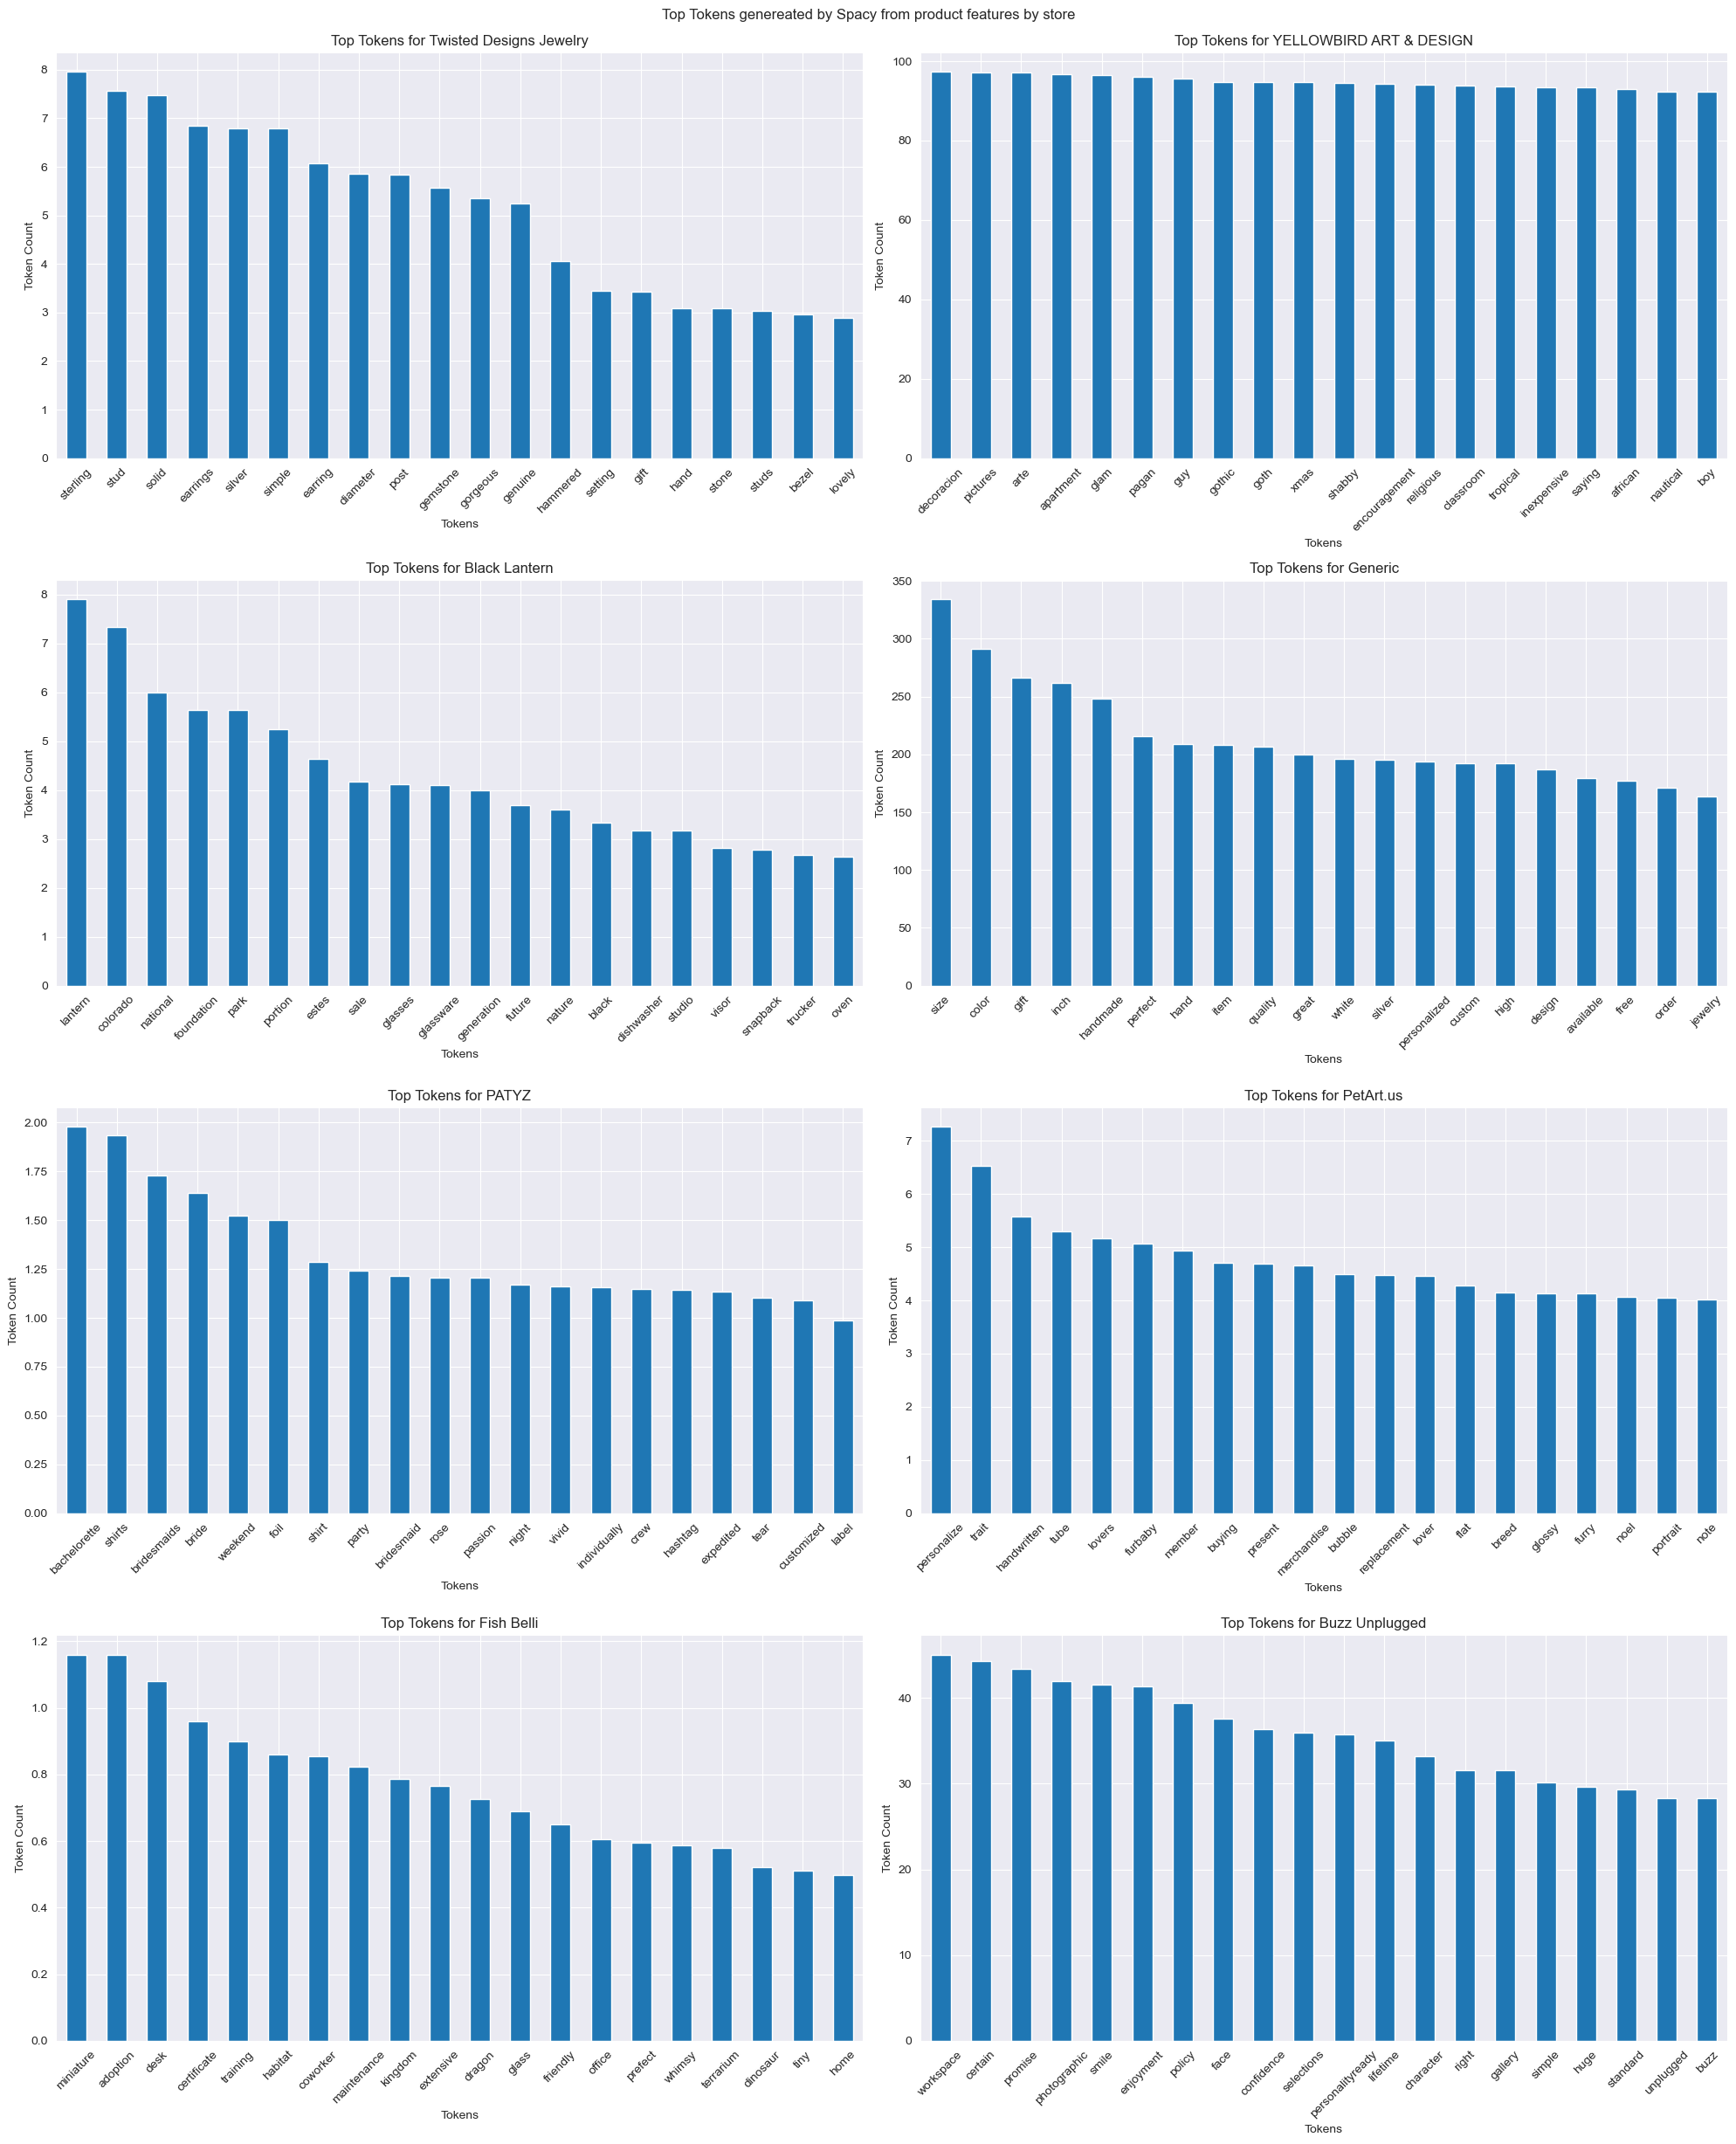

In [34]:
#visualize tokens for  products from similar store

# Extract unique store names
storenames = meta_df['store'].unique().tolist()

plt.figure(figsize=(20, 25))  

# Loop through the first 8 stores
for idx, store in enumerate(storenames[:8]):
    # Create a subplot dynamically
    plt.subplot(4, 2, idx + 1)  # 4 rows, 2 columns, current subplot position (idx + 1)
    
    # Filter rows corresponding to the current store
    rows = meta_df['store'] == store
    
    # Sum token counts for the filtered rows
    tokens_store = spacy_tokens_df[rows].sum(axis=0)
    
    # Sort tokens in descending order
    tokens_store = tokens_store.sort_values(ascending=False)
    
    # Plot top 20 tokens
    tokens_store.head(20).plot(kind='bar')

    # plt.legend()
    plt.title(f"Top Tokens for {store}")  
    plt.xticks(rotation=45)
    plt.ylabel("Token Count")
    plt.xlabel("Tokens")

plt.suptitle('Top Tokens genereated by Spacy from product features by store\n \n')

# Adjust layout to prevent overlap
plt.tight_layout() 


# Show the plot
plt.show()

Some of the most common tokens across all products include handicraft, rated, wholesaler, which align well with expectations. 
Additionally, the top tokens for each store reflect the types of products sold by that store.   

#### <a id='toc1_1_3_2_'></a>[Product title length](#toc0_)

In this section, we will explore the relationship between the length of product titles with our target variable. Essentially, we would like to see if longer titles  results in better ratings or not.

In [35]:
#storing length of product title/desc in a separate column
meta_df['product_title_length'] = meta_df['title'].apply(len).fillna(0)

meta_df['product_description_length'] = meta_df['description_product'].apply(len).fillna(0)

meta_df['product_features_length'] = meta_df['features'].apply(len).fillna(0)

meta_df['extracted_features_length'] = meta_df['spacy_tokenized_features'].apply(len).fillna(0)
meta_df['product_title_length'].describe()


count    38154.000000
mean       112.709572
std         48.727242
min          0.000000
25%         74.000000
50%        109.000000
75%        150.000000
max        236.000000
Name: product_title_length, dtype: float64

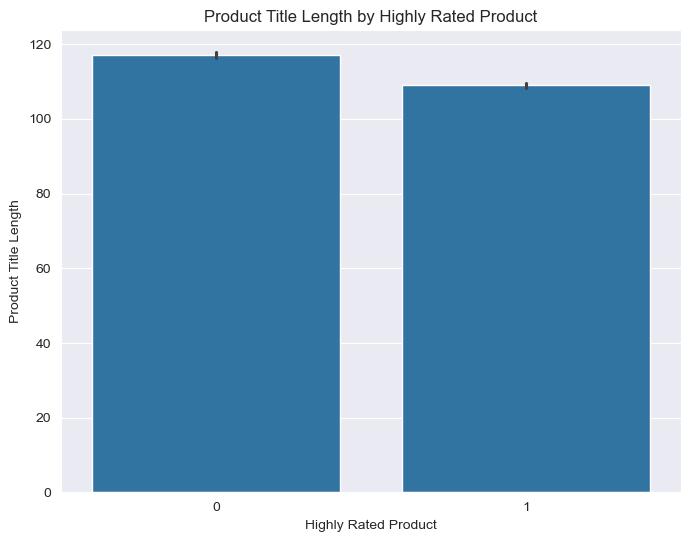

In [36]:
#Check distribution of product title lengths across target variable

# Create the bar plot
sns.barplot(data=meta_df, x='highly_rated_product', y='product_title_length')

# Add labels and title
plt.xlabel('Highly Rated Product')
plt.ylabel('Product Title Length')
plt.title('Product Title Length by Highly Rated Product')
plt.show()

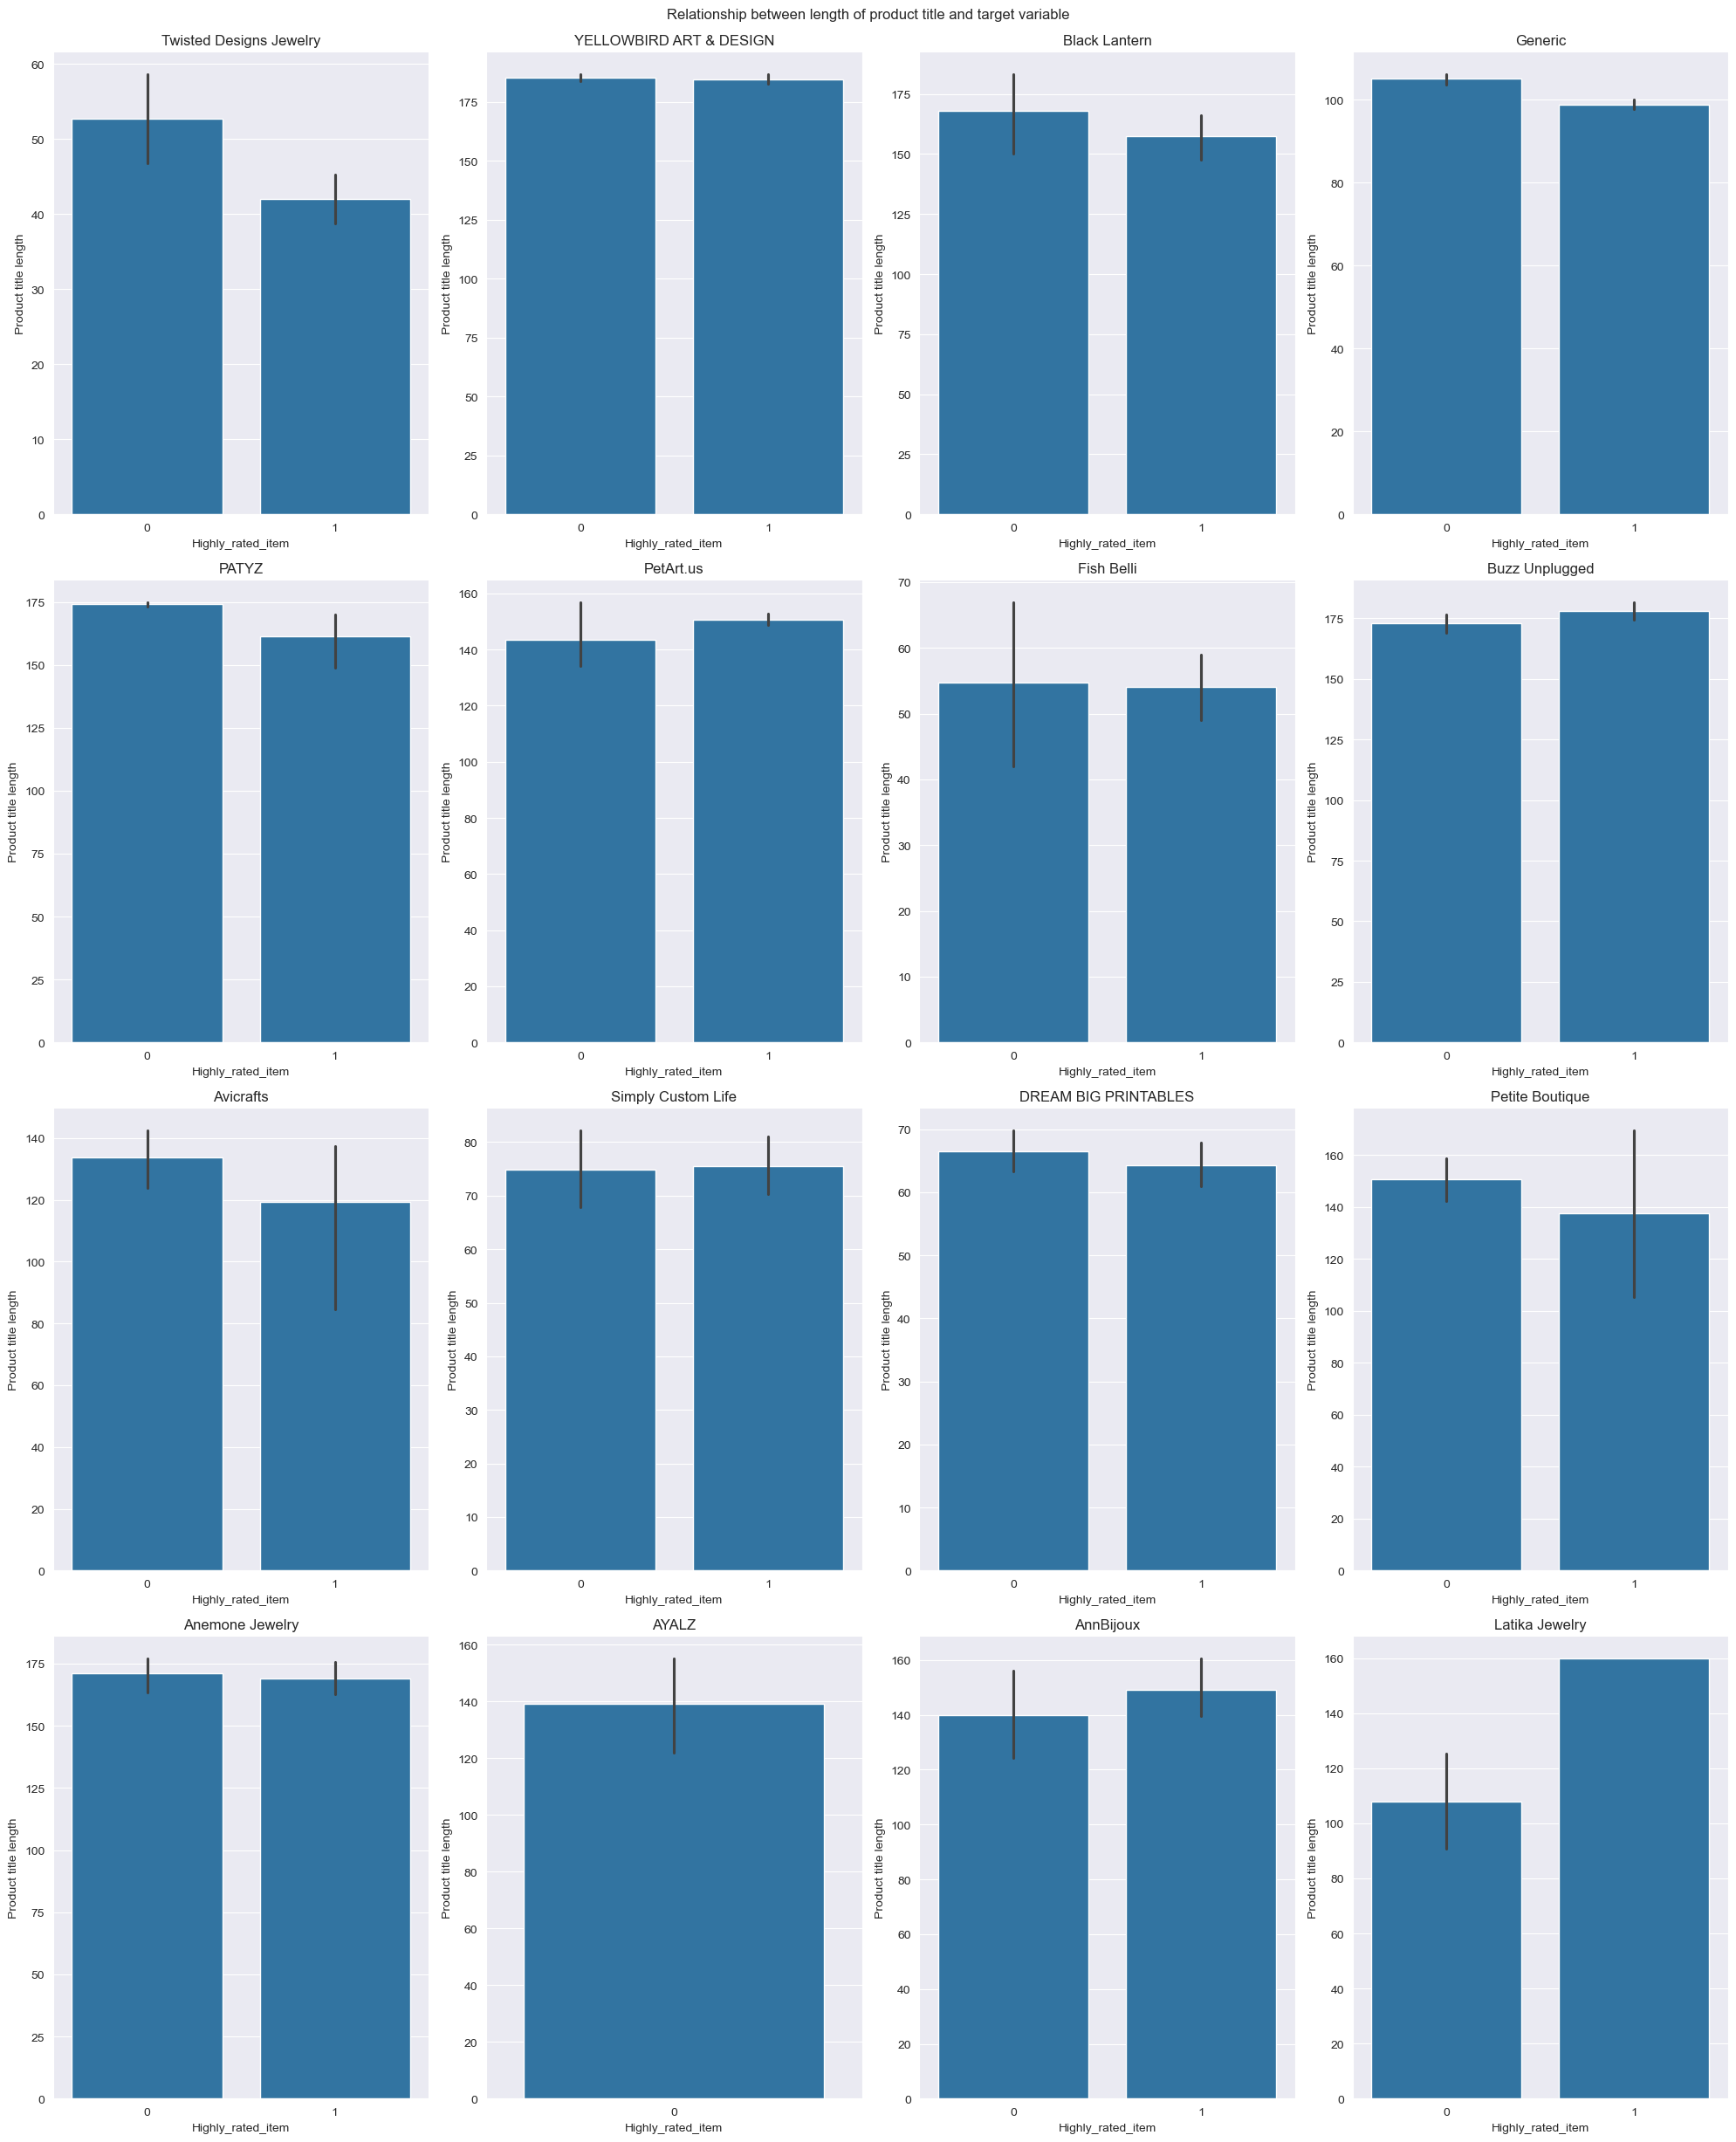

In [37]:
#For a given store- do we see any correlation between the length of the title and average rating of the product?

# Extract unique store names
storenames = meta_df['store'].unique().tolist()

plt.figure(figsize=(20, 25))  

# Loop through the first 8 stores
for idx, store in enumerate(storenames[:16]):
    # Create a subplot dynamically
    plt.subplot(4, 4, idx + 1)  # 4 rows, 2 columns, current subplot position (idx + 1)
    
    # Filter rows corresponding to the current store
    rows = meta_df['store'] == store

    sns.barplot(data = meta_df[rows],y = 'product_title_length',x ='highly_rated_product' )

    plt.title(f"{store}")  
    plt.ylabel("Product title length")
    plt.xlabel("Highly_rated_item")

plt.suptitle('Relationship between length of product title and target variable\n \n')

# Adjust layout to prevent overlap
plt.tight_layout() 


# Show the plot
plt.show()


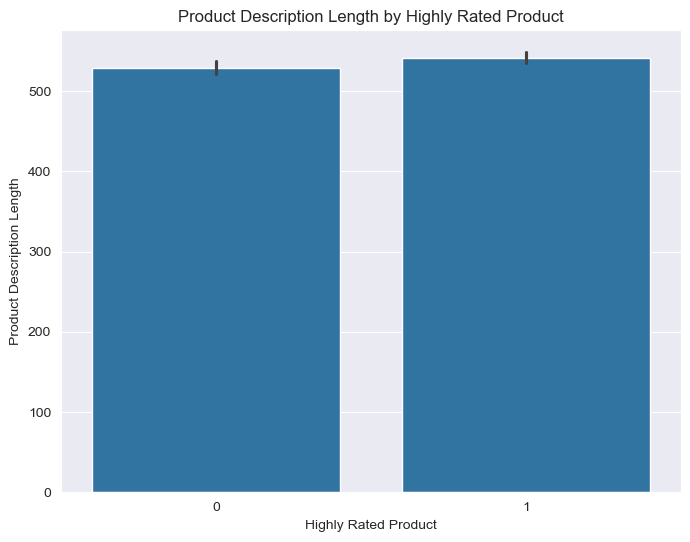

In [38]:
#Check distribution of product description lengths across target variable

# Create the bar plot
sns.barplot(data=meta_df, x='highly_rated_product', y='product_description_length')

# Add labels and title
plt.xlabel('Highly Rated Product')
plt.ylabel('Product Description Length')
plt.title('Product Description Length by Highly Rated Product')
plt.show()

**Key Insights**
- For overall dataset, we see that the mean title length of low rated products is slightly higher than high rated products.

- At a store level, we also see that some stores have high rated items with longer titles, while for some other stores, title length doesn't have a relationship with the rating of an item. 

- The mean of product's description length is slightly higher for highly rated products. However since 40% of the dataset has missing descriptions, this might not be a reliable feature in our model.

### <a id='toc1_1_4_'></a>[Dealing with store column](#toc0_)

In [39]:
#inspect values in store column
meta_df['store'].unique()[:10]

array(['Twisted Designs Jewelry', 'YELLOWBIRD ART & DESIGN',
       'Black Lantern', 'Generic', 'PATYZ', 'PetArt.us', 'Fish Belli',
       'Buzz Unplugged', 'Avicrafts', 'Simply Custom Life'], dtype=object)

We notice that some store names are in capital letters,  therefore lets check the no of unique store names after changing to lower case.

In [40]:
print(f"There are {meta_df['store'].nunique()- meta_df['store'].str.lower().nunique()} duplicate labels for stores.")

There are 25 duplicate labels for stores.


In [41]:
#combine duplicate labels
meta_df['store'] = meta_df['store'].str.lower()

print(f"There are {meta_df['store'].nunique()} unique stores/sellers in the dataset.")


There are 3455 unique stores/sellers in the dataset.


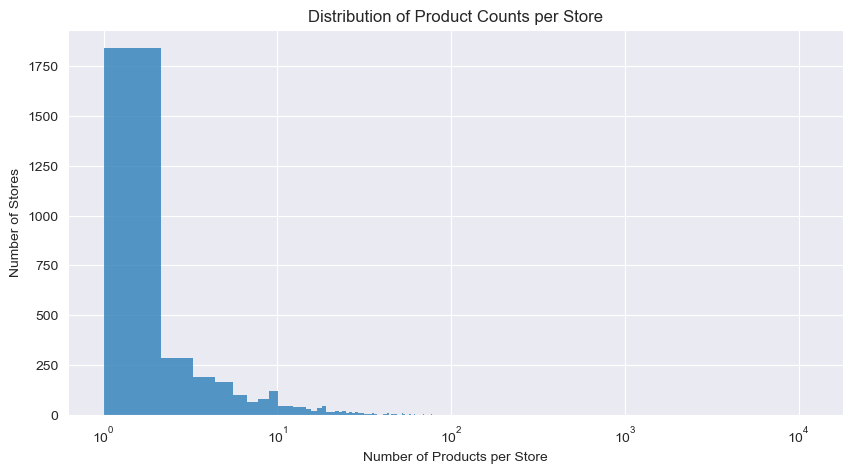

In [42]:
#Checking the size of stores in the dataset
store_counts = meta_df["store"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(store_counts,bins=10000)
plt.xscale('log')
plt.xlabel("Number of Products per Store")
plt.ylabel("Number of Stores")
plt.title("Distribution of Product Counts per Store")
plt.show()

In [43]:
store_counts.describe()

count     3455.000000
mean        11.043126
std        193.919148
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      11323.000000
Name: count, dtype: float64

In [44]:
num = store_counts[store_counts == 1].sum()/len(store_counts)*100
print(f'There are {np.round(num)}% of stores with only 1 product.')

There are 40.0% of stores with only 1 product.


**Key Insights**
- Most of the stores in the dataset have 2 or products per store. Specifically, about 40% of stores have only 1 product in their store. 
- Looks like the "generic store" is a placeholder for  many different stores and it dominates the dataset.

Lets look at the distribution of ratings within these stores.

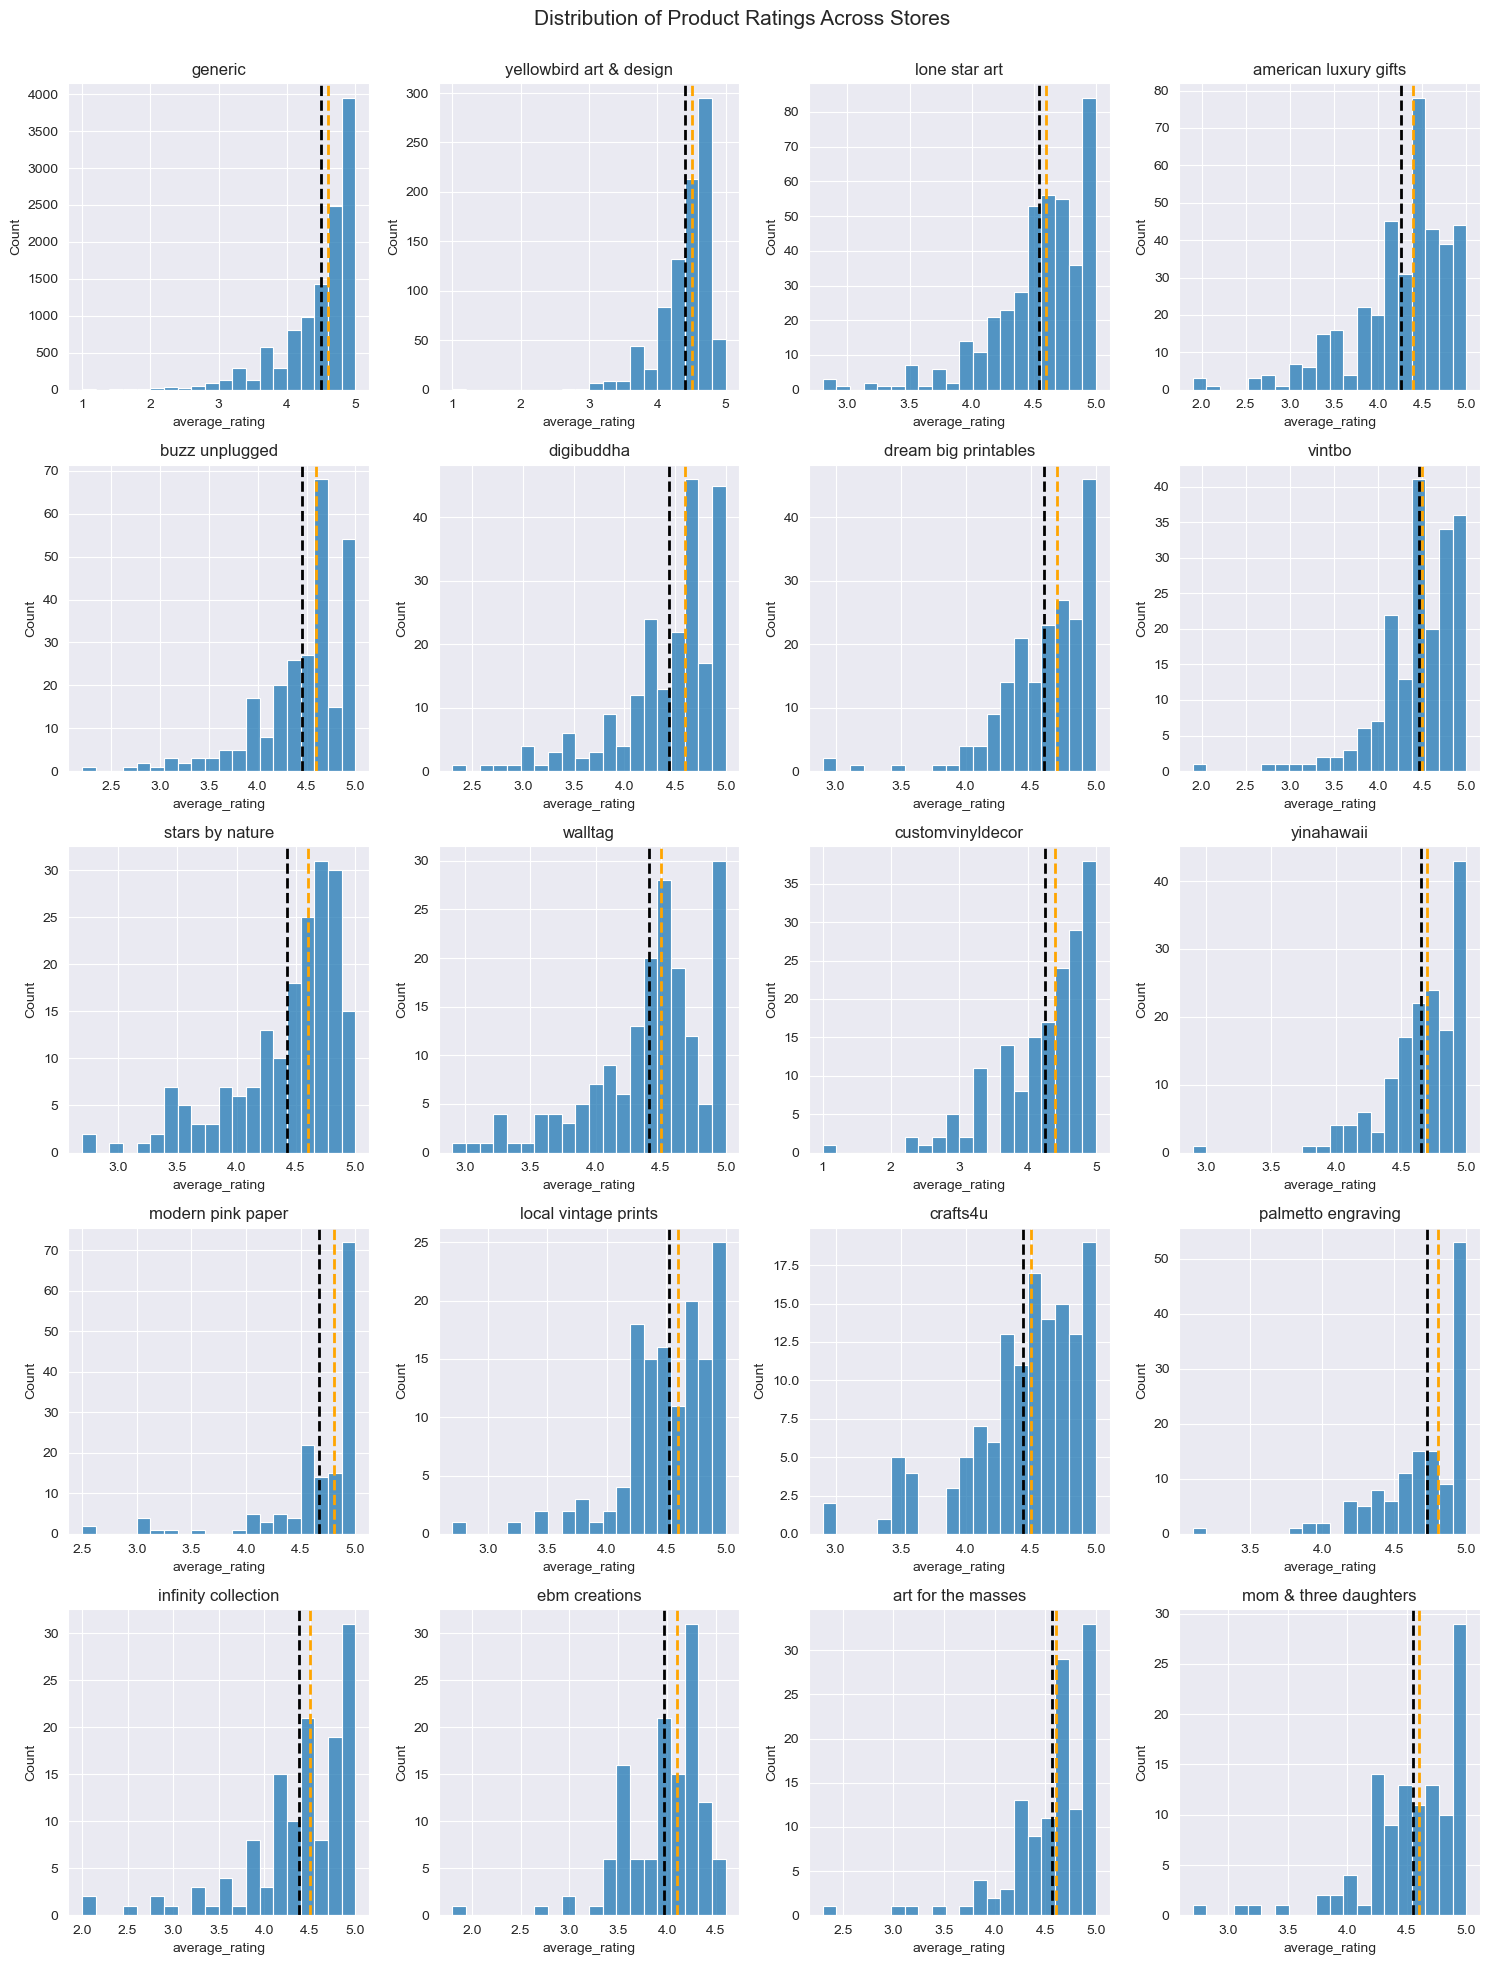

In [45]:
#we only filter stores with more than 100 items - for visualization purposes only
relevant_stores = meta_df['store'].value_counts().loc[lambda x: x>100].index.tolist()

plt.subplots(5,4, figsize=(15,20)) # creating subplots structure with 4 rows and 3 columns 

for idx, store in enumerate(relevant_stores): 
 
    plt.subplot(5, 4, idx+1)

    # plot
    sns.histplot(meta_df[meta_df['store'] == store]['average_rating'], bins=20, edgecolor='white')
    plt.axvline(meta_df[meta_df['store'] == store]['average_rating'].mean(), 
                label="Mean", color='black', ls='--', lw=2) # mean vertical line
    plt.axvline(meta_df[meta_df['store'] == store]['average_rating'].median(), 
                label="Median", color='orange', ls='--', lw=2) # median vertical line

    # add title + label
    plt.ylabel("Count")
    plt.title(f'{store}')

plt.suptitle("Distribution of Product Ratings Across Stores \n\n", fontsize=15)
plt.tight_layout()

plt.show()

Most stores exhibit a right-skewed distribution, as ratings are heavily concentrated on the higher end. However, the degree of skewness varies across different stores.  
Lets check the distribution of our target variable for these stores.


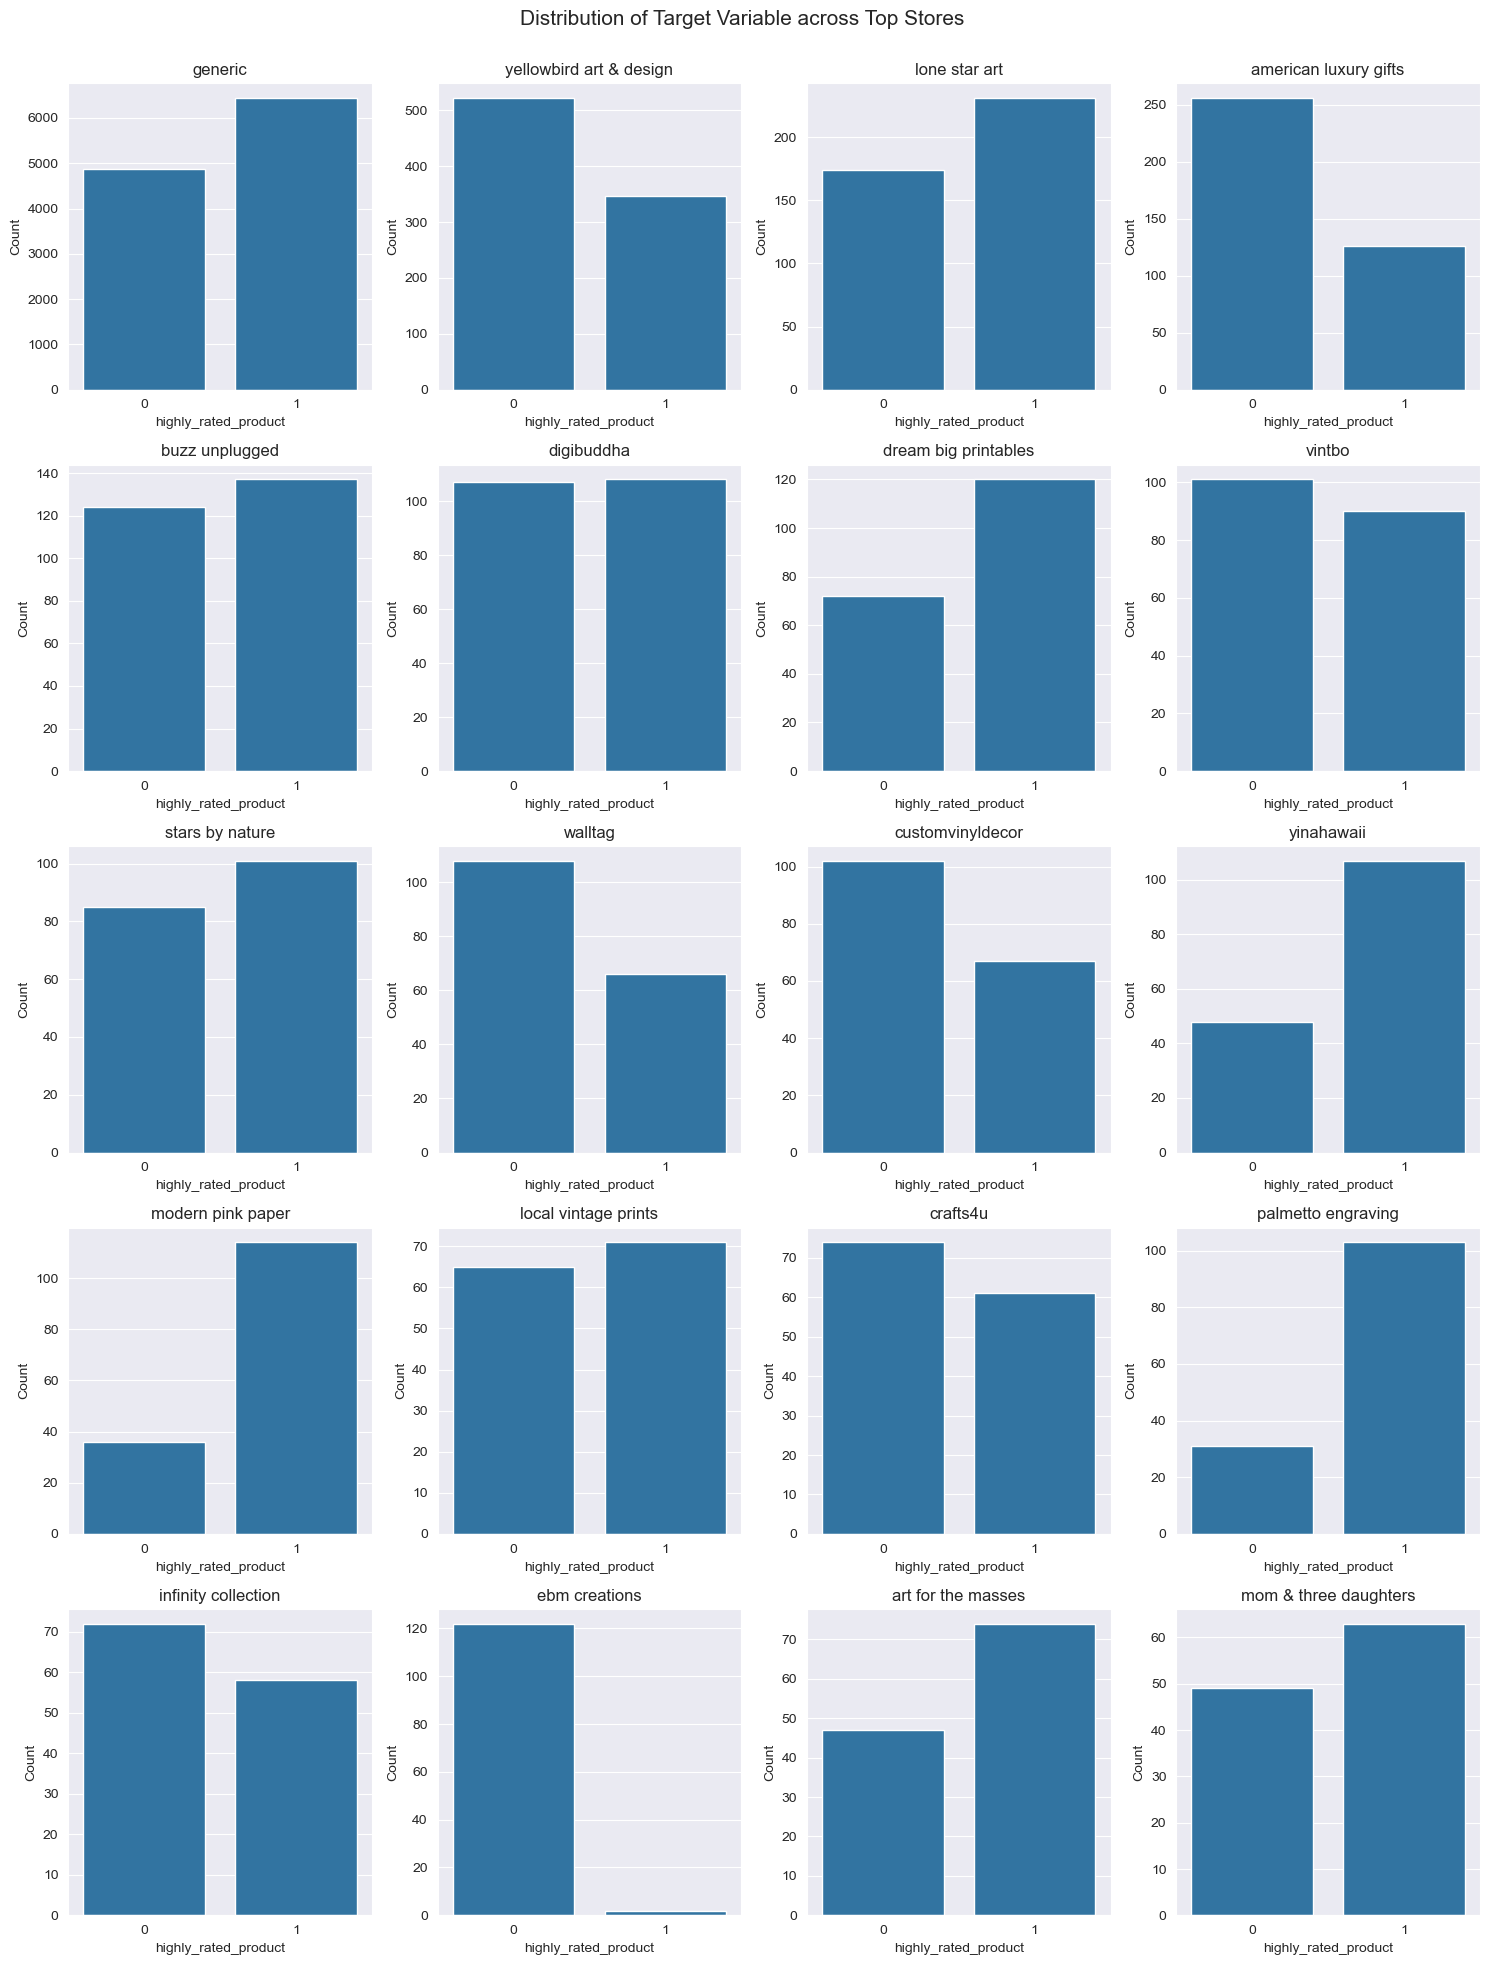

In [46]:
#plot distribution of target variable across different stores 
plt.subplots(5,4, figsize=(15,20)) # creating subplots structure with 4 rows and 3 columns 

for idx, store in enumerate(relevant_stores): 

    #specify destination of plot 
    plt.subplot(5, 4, idx+1) # adding +1 because subplot positions start from 1

    # plot
    sns.countplot(meta_df[meta_df['store'] == store], x = 'highly_rated_product')
    
    # add title + label
    plt.ylabel("Count")
    plt.title(f'{store}')

plt.suptitle("Distribution of Target Variable across Top Stores \n\n", fontsize=15)
plt.tight_layout()

plt.show()

Here we can more clearly see the differences across different stores.

Stores like Infinity Collection, Walltag and Crafts4U have a higher number of low-rated products than high-rated products. In contrast, stores such as yinahawaii and Palmetto engraving have a significantly larger number of  high-rated products.

Therefore Store could be a useful predictor for our model. 

To improve generalization, we will also group stores with more than 5 products. Since a single product does not provide enough data for the model to learn generalizable patterns, grouping these stores helps reduce noise and mitigate overfitting.  


Next we will explore new features based on store-level attributes:  
- Number of unique products sold by each store.  
- Average rating of products sold by a given store.
- Standard Deviation of rating of products sold by a given store.

In [47]:
#create a grouped store coulmn that groups stores with 5 or less products
meta_df['store_grouped'] = meta_df['store'].apply(lambda x: x if store_counts[x] > 5 else 'small stores')

meta_df['store_grouped'].value_counts()

store_grouped
generic                    11323
small stores                4742
yellowbird art & design      868
lone star art                405
american luxury gifts        382
                           ...  
bear natural organics          6
kareily                        6
inthetime                      6
studio meme                    6
wyguyo                         6
Name: count, Length: 977, dtype: int64

In [48]:
print(f'There are {meta_df["store_grouped"].isna().sum()} missing values in the store_grouped column.')

There are 0 missing values in the store_grouped column.


In [49]:
#Construct new features - store based total products and average rating

store_grouped_counts = meta_df['store_grouped'].value_counts()

## Map the number of products to the grouped store column
meta_df['store_grouped_total_products'] = meta_df['store_grouped'].map(store_grouped_counts)

# Apply log transformation
meta_df['log_store_grouped_total_products'] = np.log10(meta_df['store_grouped_total_products'])

# Calculate the std in average rating per grouped store
store_grouped_std_rating = meta_df.groupby('store_grouped')['average_rating'].std()

# Map the std back to the DataFrame 
meta_df['store_grouped_std_rating'] = meta_df['store_grouped'].map(store_grouped_std_rating)

# Calculate the median rating per grouped store
store_grouped_median_rating_number = meta_df.groupby('store_grouped')['rating_number'].median()

# Map the median rating back to the DataFrame 
meta_df['store_grouped_median_rating_number'] = meta_df['store_grouped'].map(store_grouped_median_rating_number)

# Calculate the mean in average rating per grouped store
store_grouped_mean_rating = meta_df.groupby('store_grouped')['average_rating'].mean()

# Map the mean back to the DataFrame 
meta_df['store_grouped_mean_rating'] = meta_df['store_grouped'].map(store_grouped_mean_rating)

# Apply log transformation
meta_df['log_store_grouped_mean_rating'] = np.log10(meta_df['store_grouped_mean_rating'])

#Calculate the weighted mean of average rating per grouped store
def weighted_mean_rating(group):
    return (group['average_rating'] * group['store_grouped_total_products']).sum() / group['store_grouped_total_products'].sum()

# Group by 'store_grouped' and calculate the weighted mean
store_grouped_weighted_mean_rating = meta_df.groupby('store_grouped').apply(weighted_mean_rating)

#Map the weighted mean back to the DataFrame
meta_df['store_grouped_weighted_mean_rating'] = meta_df['store_grouped'].map(store_grouped_weighted_mean_rating)

#Apply log
meta_df['log_store_grouped_weighted_mean_rating'] = np.log10(meta_df['store_grouped_weighted_mean_rating'])



In [50]:
#Adding another column that calculates the ratio of low rated items to high rated items per store

# Count the number of items with average_rating < 4.5 per store_grouped
low_rated_counts = meta_df[meta_df['average_rating'] < 4.5].groupby('store_grouped').size()

# Count the number of items with average_rating >= 4.5 per store_grouped
high_rated_counts = meta_df[meta_df['average_rating'] >= 4.5].groupby('store_grouped').size()

#Calculate the ratio of low-rated to high-rated items
low_rated_ratio = (low_rated_counts / high_rated_counts).fillna(0)  # Fill NaN with 0 where high_rated_counts is 0

# Map the ratio back to the DataFrame
meta_df['store_grouped_low_rated_ratio'] = meta_df['store_grouped'].map(low_rated_ratio)

meta_df['store_grouped_low_rated_ratio'].describe()

count    38154.000000
mean         0.898670
std          1.805902
min          0.000000
25%          0.473684
50%          0.575922
75%          0.653846
max         30.000000
Name: store_grouped_low_rated_ratio, dtype: float64

### <a id='toc1_1_5_'></a>[Product Age](#toc0_)

<Axes: xlabel='highly_rated_product', ylabel='product_age_days'>

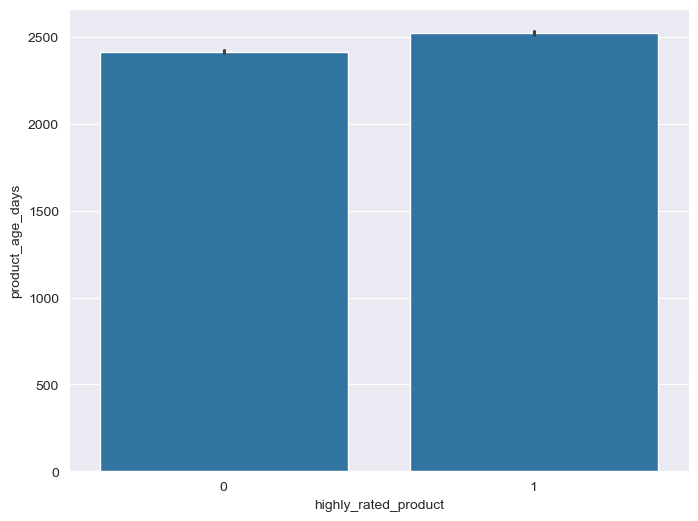

In [51]:
# Calculate the age of the product in days
meta_df['product_age_days'] = (pd.Timestamp.today() - meta_df['date_first_available']).dt.days

sns.barplot(x='highly_rated_product',y='product_age_days',data=meta_df)


Older products seem to be associated with slightly higher ratings, however the difference is minimal.

### <a id='toc1_1_6_'></a>[ Sub_categories and Department columns](#toc0_)

After inital cleaning of the data, we have different hierarchical categories of a product (upto sub_category level 3). However as we go down the hierarchy, some categories only have as low as 1 product and from a modeling perspective, these categories aren't ideal as they have so little data. 

We could combine the most broad level category (aka sub_category1) and the next hierarchical category (sub_category2) for all the products in the dataset. Furthermore, at a given sub_category_1, we will group all sub categories at level 2 with very few products.

In [52]:
#drop the original combined_category as we will be replacing this with a new one

meta_df.drop(columns="combined_category",inplace=True)

In [53]:
meta_df['sub_category_1'].value_counts()

sub_category_1
Home & Kitchen                   16302
Jewelry                          11593
Clothing, Shoes & Accessories     3870
Stationery & Party Supplies       3161
Beauty & Grooming                 1001
Sports & Outdoors                  657
Electronics Accessories            461
Pet Supplies                       361
Toys & Games                       301
Baby                               249
Health & Personal Care             198
Name: count, dtype: int64

In [54]:
meta_df['sub_category_2'].describe()

count       38154
unique         75
top       Artwork
freq         7350
Name: sub_category_2, dtype: object

In [55]:
# This function combines sub_category_1 label and sub_category_2 label into a single 'combined_category' field. 
# It combines all the sub_categories within main category that have fewer products than min_threshold

def combine_categories(row, category_counts, min_threshold=10):
    """
    Combines sub_category_1 and sub_category_2.
    

    Args:
    row (pd.Series): A row of the DataFrame.
    category_counts (dict): A dictionary mapping combined categories to their counts.
    min_threshold (int): Minimum number of rows a category should have.

    Returns:
    str: Concatenated string of sub_category_1 and adjusted sub_category_2.
    """
    no_duplicate_combined = []
    
    sub_category_1 = row['sub_category_1']
    sub_category_2 = row['sub_category_2']
    
    combined = f"{sub_category_1} {sub_category_2}"

    # If count is below threshold, replace sub_category_2 with 'Other'
    if category_counts.get(combined, 0) < min_threshold:
        return f"{sub_category_1} Other"
    
    # Remove duplicate words
    for x in re.split(r"[, ]+", combined): 
        if x not in no_duplicate_combined:
            no_duplicate_combined.append(x)
    
    combined_category = ' '.join(no_duplicate_combined)
    return combined_category


In [56]:
#temporarily store combine category
meta_df['combined_category_temp'] = meta_df['sub_category_1'] + ' ' + meta_df['sub_category_2']
#compute category counts
category_counts = meta_df['combined_category_temp'].value_counts().to_dict()
# Apply function to create final combined category
meta_df['combined_category'] = meta_df.apply(lambda row: combine_categories(row, category_counts), axis=1)

# Drop temporary column
meta_df.drop(columns=['combined_category_temp'], inplace=True)

meta_df['combined_category'].value_counts()

combined_category
Home & Kitchen Artwork          7350
Home & Kitchen Décor            6006
Jewelry Necklaces               3775
Stationery & Party Supplies     3161
Jewelry Earrings                2899
                                ... 
Baby Pacifiers & Teethers         11
Toys & Games Other                 9
Sports & Outdoors Other            6
Baby Other                         4
Health & Personal Care Other       2
Name: count, Length: 68, dtype: int64

In [57]:
#Only selecting rows where combined_category has 10 or higher products
valid_categories = meta_df['combined_category'].value_counts().loc[lambda x: x >= 10].index  

# Filter meta_df to only include rows with those categories
meta_df = meta_df[meta_df['combined_category'].isin(valid_categories)].reset_index()

Lets look at the distribution of highly rated products for sub-category-1 and sub-category-2.

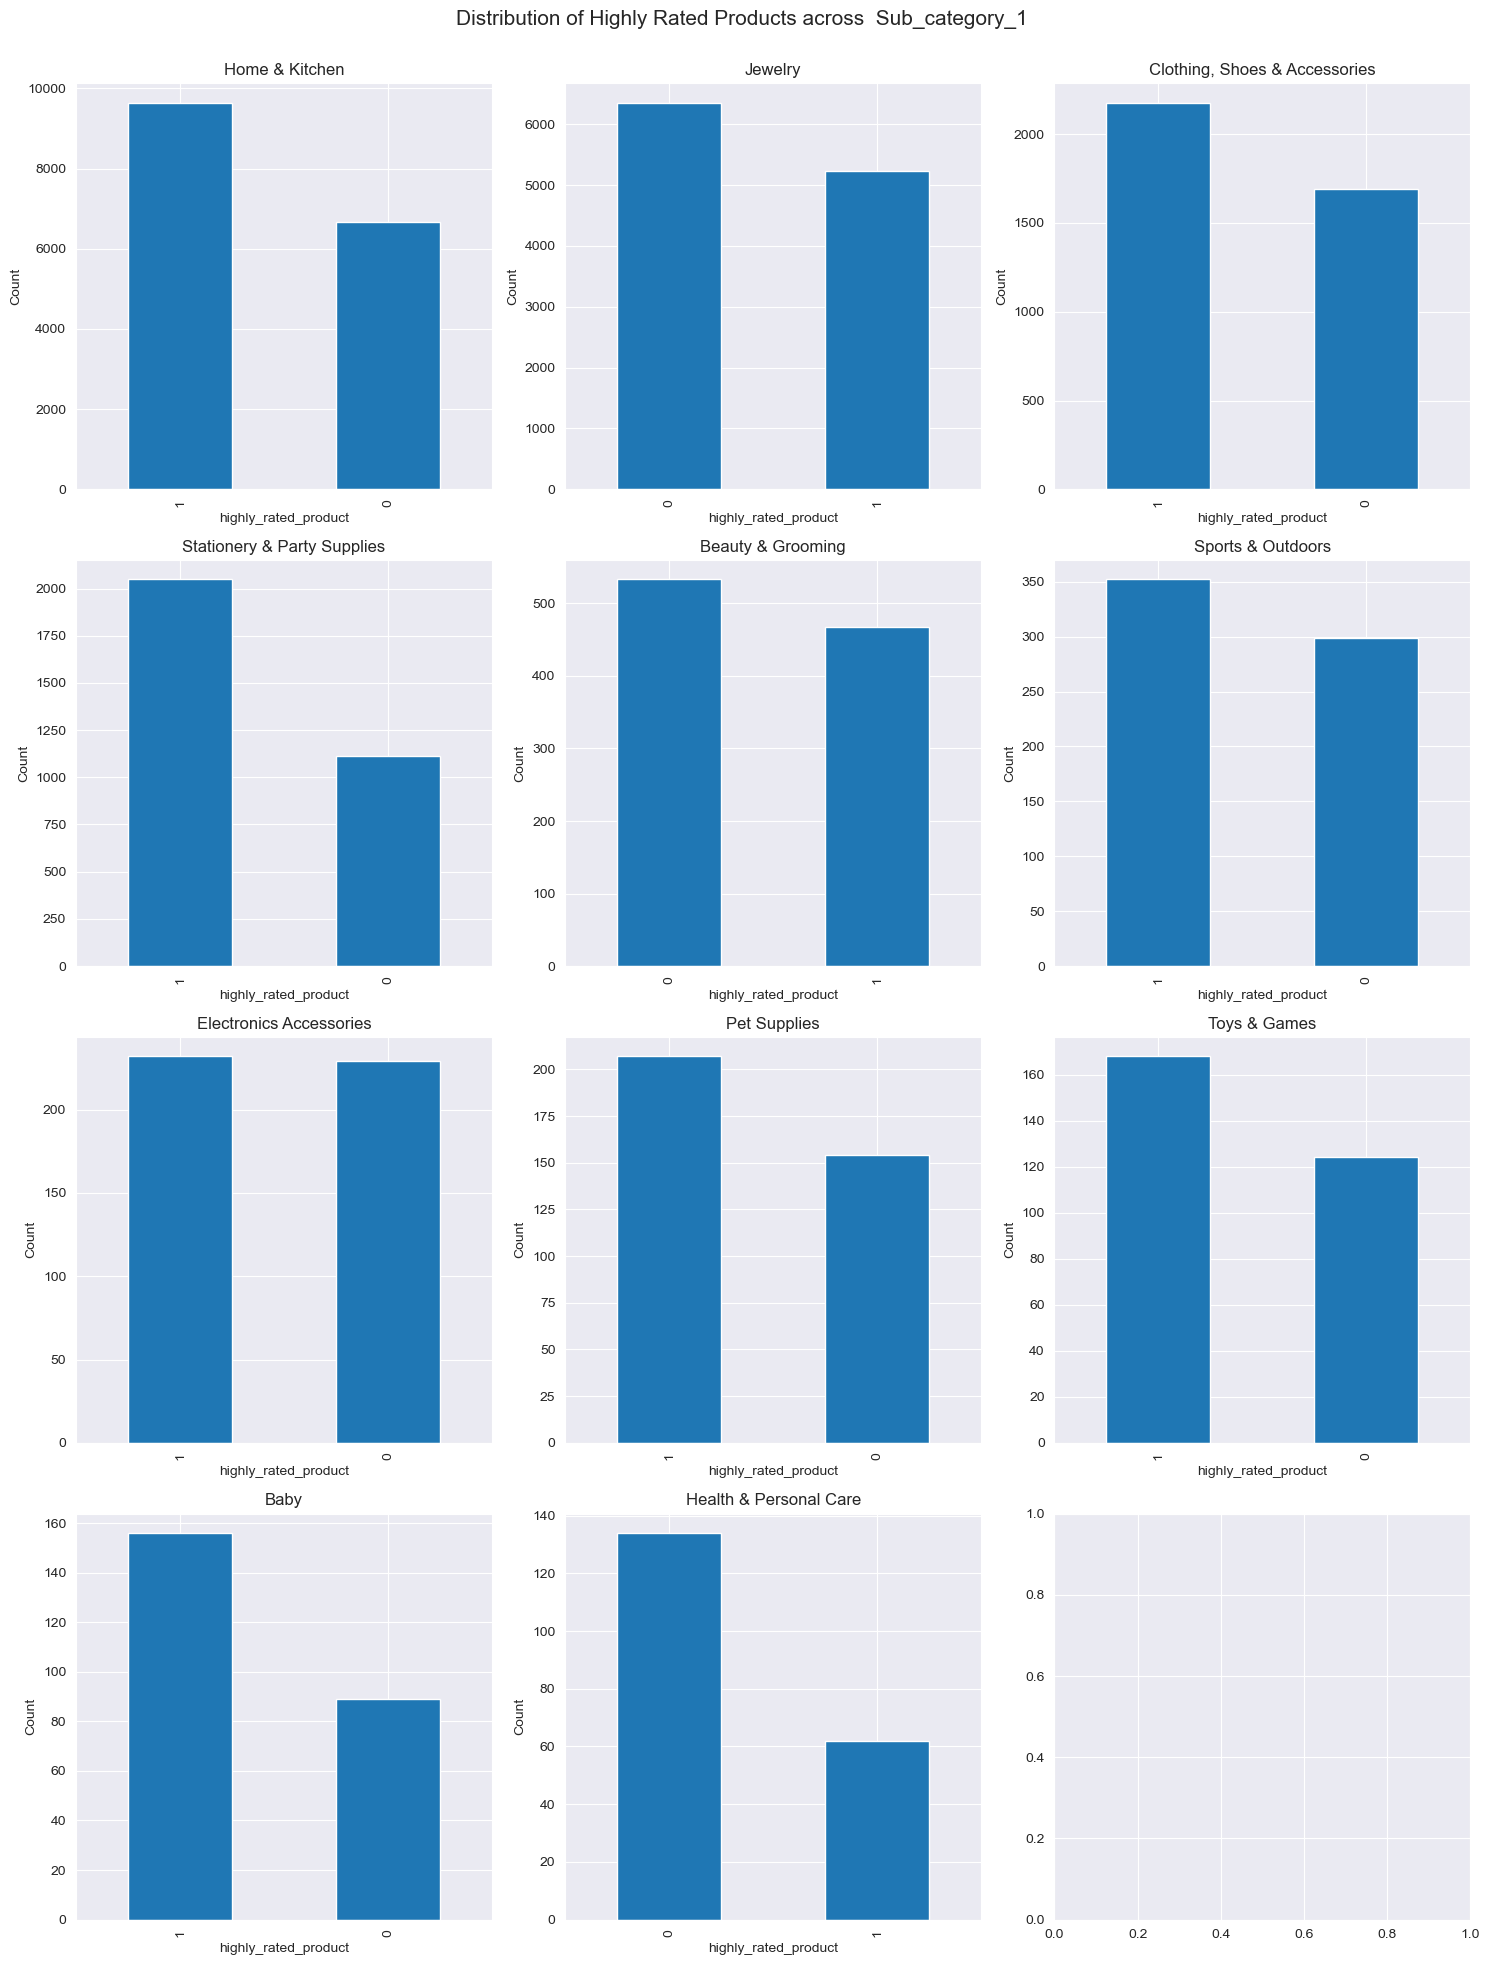

In [58]:
relevant_subcat = meta_df['sub_category_1'].value_counts().index.tolist()

plt.subplots(4,3, figsize=(15,20)) # creating subplots structure with 4 rows and 3 columns 

for idx, subcat in enumerate(relevant_subcat): 

    #specify destination of plot 
    plt.subplot(4, 3, idx+1) # adding +1 because subplot positions start from 1

    # plot
    meta_df[meta_df['sub_category_1'] == subcat]['highly_rated_product'].value_counts().plot(kind='bar')
    
    # add title + label
    plt.ylabel("Count")
    plt.title(f'{subcat}')

plt.suptitle("Distribution of Highly Rated Products across  Sub_category_1 \n\n", fontsize=15)
plt.tight_layout()

plt.show()

Despite the imbalance in our dataset, we see some categories have higher number of low rated products than high-rated. Therefore using sub-catgory-1 could help differentiate product's average rating. Lets also look at the distribution of target variable across sub-category-2

In [59]:
relevant_subcat = meta_df['combined_category'].value_counts().loc[lambda x: (x>30) & (x<50)].index.tolist()
len(relevant_subcat)

14

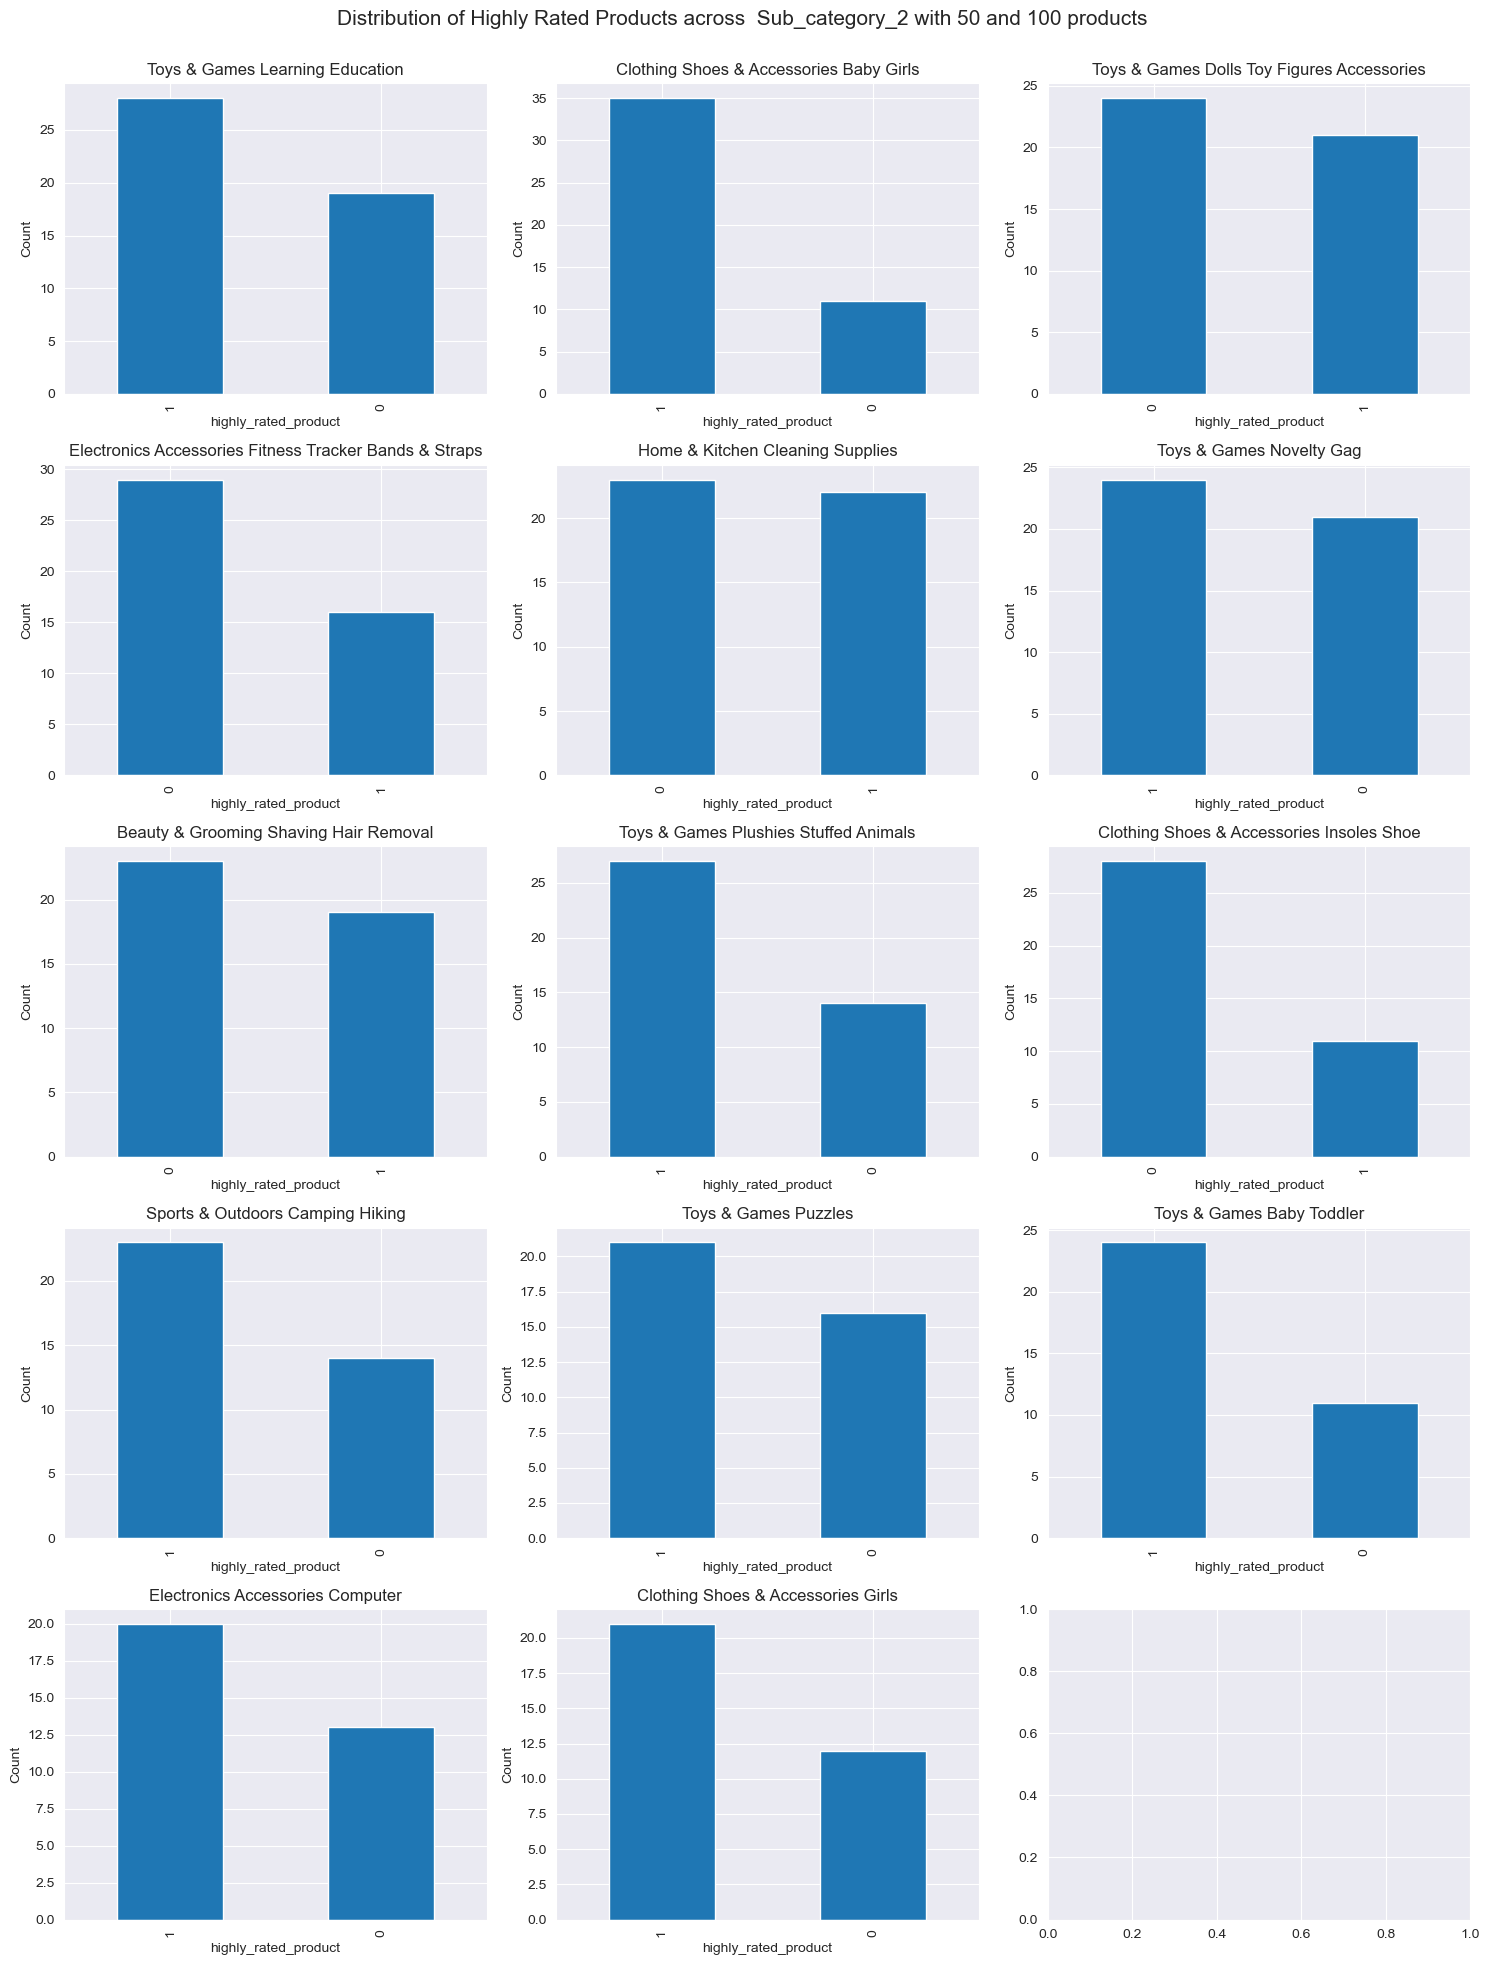

In [60]:
plt.subplots(5,3, figsize=(15,20)) # creating subplots structure with 4 rows and 3 columns 

for idx, subcat in enumerate(relevant_subcat): 

    #specify destination of plot 
    plt.subplot(5, 3, idx+1) # adding +1 because subplot positions start from 1

    # plot
    meta_df[meta_df['combined_category'] == subcat]['highly_rated_product'].value_counts().plot(kind='bar')
    
    # add title + label
    plt.ylabel("Count")
    plt.title(f'{subcat}')

plt.suptitle("Distribution of Highly Rated Products across  Sub_category_2 with 50 and 100 products \n\n", fontsize=15)
plt.tight_layout()

plt.show()

Some sub-categories have more low rated items than high-rated. Lets do a more thorough check on all the sub categories

In [61]:
meta_df.groupby('combined_category')['highly_rated_product'].agg(['mean', 'count']).loc[lambda x: x['mean'] < 0.5]

,mean,count
combined_category,,
Baby Health Bathing & Skin Care,0.200000,15
Beauty & Grooming Fragrance,0.232394,142
Beauty & Grooming Makeup,0.342466,73
Beauty & Grooming Shaving Hair Removal,0.452381,42
Beauty & Grooming Skin Care,0.465181,359
Clothing Shoes & Accessories Insoles Shoe,0.282051,39
Clothing Shoes & Accessories Women,0.475819,641
Electronics Accessories Camera & Photo,0.380952,21
Electronics Accessories Cell Phone,0.397436,156


There a few subcategories with more low rated items than high rated. This might be a useful feature for the model.

#### <a id='toc1_1_6_1_'></a>[Aggregating ratings per combined-category](#toc0_)

In [62]:
#Create new columns that represents a mean, std and size of ratings within the combined sub-category

#Calculate different metrics for sub_category_1
subcategory1_stats = meta_df.groupby('sub_category_1').agg(
    subcategory1_mean_rating=('average_rating', 'mean'),
    subcategory1_total_products=('average_rating', 'size'),
    subcategory1_mean_rating_number=('rating_number', 'mean'),
    subcategory1_std_rating=('average_rating', 'std'),
    subcategory1_std_rating_number=('rating_number', 'std')
)

# Merge the results back into meta_df
meta_df = meta_df.merge(subcategory1_stats, on='sub_category_1')

# Calculate different metrics for sub_category_2
combined_stats = meta_df.groupby('combined_category').agg(
    combined_category_mean_rating=('average_rating', 'mean'),
    combined_category_total_products=('average_rating', 'size'),
    combined_category_mean_rating_number=('rating_number', 'mean'),
    combined_category_std_rating=('average_rating', 'std'),
    combined_category_std_rating_number=('rating_number', 'std')
)

# Merge the results back into meta_df
meta_df = meta_df.merge(combined_stats, on='combined_category')

#We could also create a weighted mean for sub-category

#Calculate the weighted mean of average rating per combined category
def weighted_mean_rating(group):
    return (group['average_rating'] * group['combined_category_total_products']).sum() / group['combined_category_total_products'].sum()

# Group by 'combined_category' and calculate the weighted mean
weighted_mean_rating = meta_df.groupby('combined_category').apply(weighted_mean_rating)

#Map the weighted mean back to the DataFrame
meta_df['combined_category_weighted_mean_rating'] = meta_df['combined_category'].map(weighted_mean_rating)

meta_df['combined_category_weighted_mean_rating'].describe()

count    38133.000000
mean         4.482286
std          0.106709
min          3.941176
25%          4.425377
50%          4.517265
75%          4.544206
max          4.700000
Name: combined_category_weighted_mean_rating, dtype: float64

In [63]:
# Count the number of items with average_rating < 4.5 per combined_category
low_rated_counts = meta_df[meta_df['average_rating'] < 4.5].groupby('combined_category').size()

# Count the number of items with average_rating >= 4.5 per store_grouped
high_rated_counts = meta_df[meta_df['average_rating'] >= 4.5].groupby('combined_category').size()

#Calculate the ratio of low-rated to high-rated items
low_rated_ratio = (low_rated_counts / high_rated_counts).fillna(0)  # Fill NaN with 0 where high_rated_counts is 0

# Map the ratio back to the DataFrame
meta_df['combined_category_low_rated_ratio'] = meta_df['combined_category'].map(low_rated_ratio)

meta_df['combined_category_low_rated_ratio'].describe()

count    38133.000000
mean         0.667953
std          0.398717
min          0.200000
25%          0.473503
50%          0.543793
75%          0.789100
max          2.962687
Name: combined_category_low_rated_ratio, dtype: float64

In [64]:
# Check for nulls
meta_df.isna().sum().loc[lambda x: x>0]

sub_category_3            1840
sub_category_4           28374
package_weight_ounces    21769
package_length_inches    21230
package_width_inches     21230
package_height_inches    21230
department               22119
dtype: int64

#### <a id='toc1_1_6_2_'></a>[Checking Department column](#toc0_)

In [65]:
meta_df['department'].value_counts(dropna=False, normalize=True)

department
NaN       0.580049
women     0.247292
unisex    0.142947
men       0.026486
kids      0.002622
sports    0.000446
misc      0.000157
Name: proportion, dtype: float64

About 57% of the products don't have a department, we will drop this feature for our first round of modeling.

In [66]:
meta_df.drop(columns='department',inplace=True)

### <a id='toc1_1_7_'></a>[Package Dimensions](#toc0_)

We saw during our intial EDA that package length, width and height are strongly correlated, so one way to remove redundancy could be to create a new feature that represents the volume of the package.

In [67]:
meta_df['package_volume'] = meta_df['package_height_inches'] \
                            * meta_df['package_length_inches'] \
                            * meta_df['package_width_inches']

meta_df.drop(columns=['package_height_inches','package_length_inches','package_width_inches'],inplace=True)

meta_df[['package_volume','package_weight_ounces']].isna().mean()

package_volume           0.556736
package_weight_ounces    0.570870
dtype: float64

More than half of the data does not have information on package volume and package weights. Lets check if we see any relationship of missing weights/volumes with our target variable.

In [68]:
#We can also create a new feature that has 1 when package weight/volume is missing vs 0 when it is not

meta_df['has_package_volume'] = np.where(meta_df['package_volume'].isna(),0,1)

meta_df['has_package_weight'] = np.where(meta_df['package_weight_ounces'].isna(),0,1)


#We can also create pacakge density 
meta_df['package_density'] = meta_df['package_weight_ounces'] / meta_df['package_volume']

meta_df[['package_density','package_volume','package_weight_ounces']].head()

,package_density,package_volume,package_weight_ounces
0,0.074682,6.15943,0.46
1,0.162845,19.71200,3.21
2,NaN,315.00000,NaN
3,NaN,NaN,NaN
4,NaN,80.00000,NaN


In [69]:
meta_df.groupby('has_package_volume')['highly_rated_product'].mean()

has_package_volume
0    0.580593
1    0.498551
Name: highly_rated_product, dtype: float64

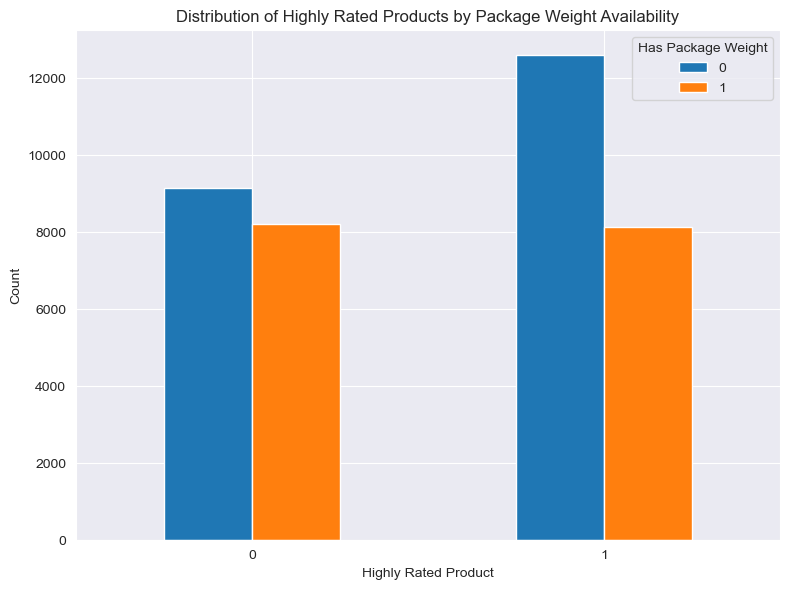

In [70]:
#check distribution of package weights with  our target variable


# Create a cross-tabulation of the two columns
cross_tab = pd.crosstab(meta_df['highly_rated_product'], meta_df['has_package_weight'], dropna=False)

# Plot the stacked bar plot
cross_tab.plot(kind='bar', stacked=False)

# Add labels and title
plt.title('Distribution of Highly Rated Products by Package Weight Availability')
plt.xlabel('Highly Rated Product')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Add a legend
plt.legend(title='Has Package Weight')

# Display the plot
plt.tight_layout()
plt.show()

There is no specific trend of missing values with our target variable. One way to impute the missing values would be to use the median by latest hierarchical sub category available for a given product.

In [71]:
#group by sub-category_4 and compare the mean and median densities of products
densities_subcategory_df = meta_df.groupby(['sub_category_4'])['package_density'].agg(
                                                                mean_package_density='mean', 
                                                                median_package_density='median',
                                                                num_products='count'
                                                            ).round(3).reset_index()
densities_subcategory_df['abs_diff'] = densities_subcategory_df['mean_package_density'] - densities_subcategory_df['median_package_density']

densities_subcategory_df.sort_values(by='num_products',ascending=False).head()

,sub_category_4,mean_package_density,median_package_density,num_products,abs_diff
127,Ornaments,0.152,0.089,661,0.063
60,Dish Cloths & Towels,0.115,0.085,214,0.030
96,Keychains & Keyrings,0.214,0.095,189,0.119
114,Men T-Shirts,0.119,0.019,170,0.100
80,Glassware,0.108,0.106,168,0.002


In [72]:
# also create an indicator for missing values
meta_df['has_package_density'] = np.where(meta_df['package_density'].isna(),0,1)
print(meta_df['has_package_density'].value_counts())

has_package_density
0    21769
1    16364
Name: count, dtype: int64


In [73]:
# fill missing densities using the median from the last sub_category available

# Step1: Precompute medians at each subcategory level
# Step2: Fill missing values by the imputed medians at the alst sub-category level available all the way till the number of missing values are zero

median_dict_4 = meta_df.groupby('sub_category_4')['package_density'].median()
meta_df["package_density"] = meta_df["package_density"].fillna(meta_df["sub_category_4"].map(median_dict_4))
print("missing values after imputation by level 4 median:", meta_df['package_density'].isna().sum())

median_dict_3 = meta_df.groupby('sub_category_3')['package_density'].median()
meta_df["package_density"] = meta_df["package_density"].fillna(meta_df["sub_category_3"].map(median_dict_3))
print("missing values after imputation by level 3 median:", meta_df['package_density'].isna().sum())

median_dict_2 = meta_df.groupby('sub_category_2')['package_density'].median()
meta_df["package_density"] = meta_df["package_density"].fillna(meta_df["sub_category_2"].map(median_dict_2))
print("missing values after imputation by level 2 median:", meta_df['package_density'].isna().sum())


missing values after imputation by level 4 median: 15825
missing values after imputation by level 3 median: 1324
missing values after imputation by level 2 median: 0


In [74]:
median_dict_1 = meta_df.groupby('sub_category_1')['package_density'].median()
meta_df["package_density"] = meta_df["package_density"].fillna(meta_df["sub_category_1"].map(median_dict_1))
print("missing values after imputation by level 1 median:", meta_df['package_density'].isna().sum())

missing values after imputation by level 1 median: 0


In [75]:
# Check remaining missing values
print("Final missing values in package density:", meta_df['package_density'].isna().sum())

Final missing values in package density: 0


### <a id='toc1_1_8_'></a>[Pickling final dataframe](#toc0_)

In [76]:
meta_df.columns

Index(['index', 'title', 'average_rating', 'rating_number', 'features',
       'description_product', 'price', 'store', 'parent_asin',
       'sub_category_1', 'sub_category_2', 'sub_category_3', 'sub_category_4',
       'date_first_available', 'package_weight_ounces', 'highly_rated_product',
       'num_product_images', 'product_features', 'spacy_tokenized_features',
       'wordnet_tokenized_features', 'product_title_length',
       'product_description_length', 'product_features_length',
       'extracted_features_length', 'store_grouped',
       'store_grouped_total_products', 'log_store_grouped_total_products',
       'store_grouped_std_rating', 'store_grouped_median_rating_number',
       'store_grouped_mean_rating', 'log_store_grouped_mean_rating',
       'store_grouped_weighted_mean_rating',
       'log_store_grouped_weighted_mean_rating',
       'store_grouped_low_rated_ratio', 'product_age_days',
       'combined_category', 'subcategory1_mean_rating',
       'subcategory1_tot

In [ ]:
#Keep required columns
cols_to_keep = ['price','highly_rated_product','product_title_length','store_grouped_total_products', 'average_rating', 'num_product_images',
       'store_grouped_weighted_mean_rating','store_grouped_std_rating','has_package_density','package_density',
       'product_age_days','store_grouped','parent_asin','subcategory1_total_products', 'subcategory1_mean_rating', 'subcategory1_std_rating',
        'subcategory1_std_rating_number','combined_category_weighted_mean_rating','combined_category_total_products', 'combined_category_mean_rating_number',
        'combined_category_std_rating_number','spacy_tokenized_features','combined_category']

meta_final_df = meta_df[cols_to_keep]

#Rename price column
meta_final_df.rename(columns = {'price' :'product_price'},inplace=True)
meta_final_df.columns

Index(['product_price', 'highly_rated_product', 'product_title_length',
       'log_store_grouped_total_products', 'average_rating',
       'num_product_images', 'log_store_grouped_weighted_mean_rating',
       'store_grouped_std_rating', 'has_package_density', 'package_density',
       'product_age_days', 'store_grouped', 'parent_asin',
       'subcategory1_total_products', 'subcategory1_mean_rating',
       'subcategory1_std_rating', 'subcategory1_std_rating_number',
       'combined_category_weighted_mean_rating',
       'combined_category_total_products',
       'combined_category_mean_rating_number',
       'combined_category_std_rating_number', 'spacy_tokenized_features',
       'combined_category'],
      dtype='object')

In [84]:
print(f'The shape of the final pre-processed dataframe is {meta_final_df.shape}.')

The shape of the final pre-processed dataframe is (38133, 23).


In [78]:
# Pickle the DataFrame
meta_final_df.to_pickle('../data/meta_sample_preprocessed.pkl')